In [4]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, push_notebook
from bokeh.models import HoverTool, CustomJS, Slider, ColumnDataSource
from bokeh.layouts import row, column, gridplot
import trackpy as tp
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import label

output_notebook()
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(50, 50))
mpl.rc('image', cmap='viridis')
plt.style.use('ggplot')
mpl.rc('xtick', labelsize=82)
mpl.rc('ytick', labelsize=82)
mpl.rcParams['font.size'] = 82

Loading BokehJS ...

In [113]:
file_dir = 'C:\\Users\\aquiles\\Data\\2018-07-10\\run4'
filename = 'data.h5'
with h5py.File(os.path.join(file_dir, filename)) as file:
    data = file['Basler data'][:,:,:]
frames = np.linspace(1, data.shape[0], data.shape[0])

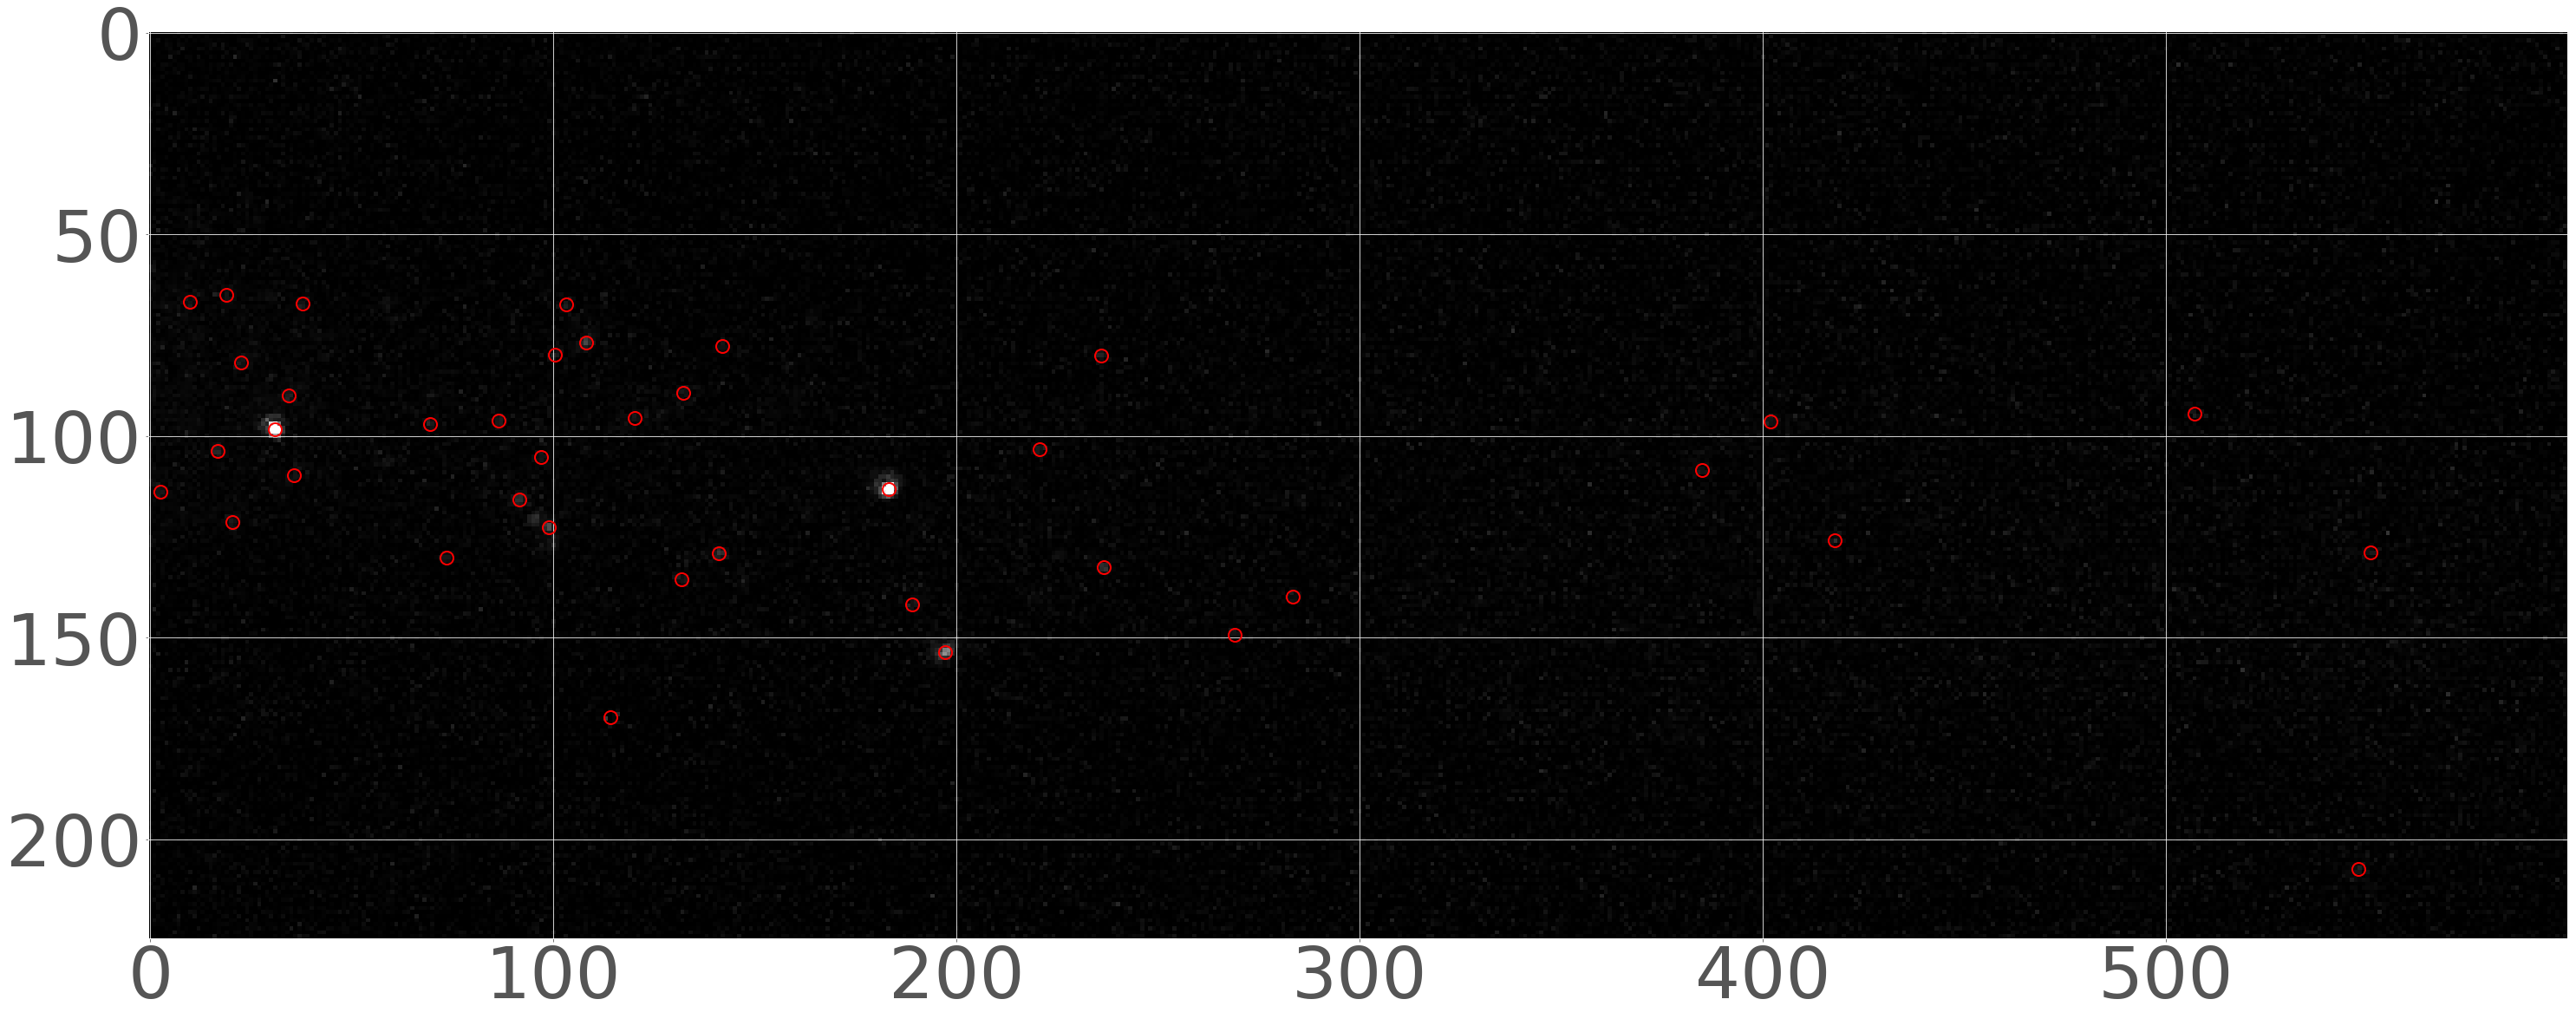

In [92]:
f = tp.locate(data[0, :,:], 7, minmass=800)
plt.figure()  # make a new figure
tp.annotate(f, data[0, : ,:]);

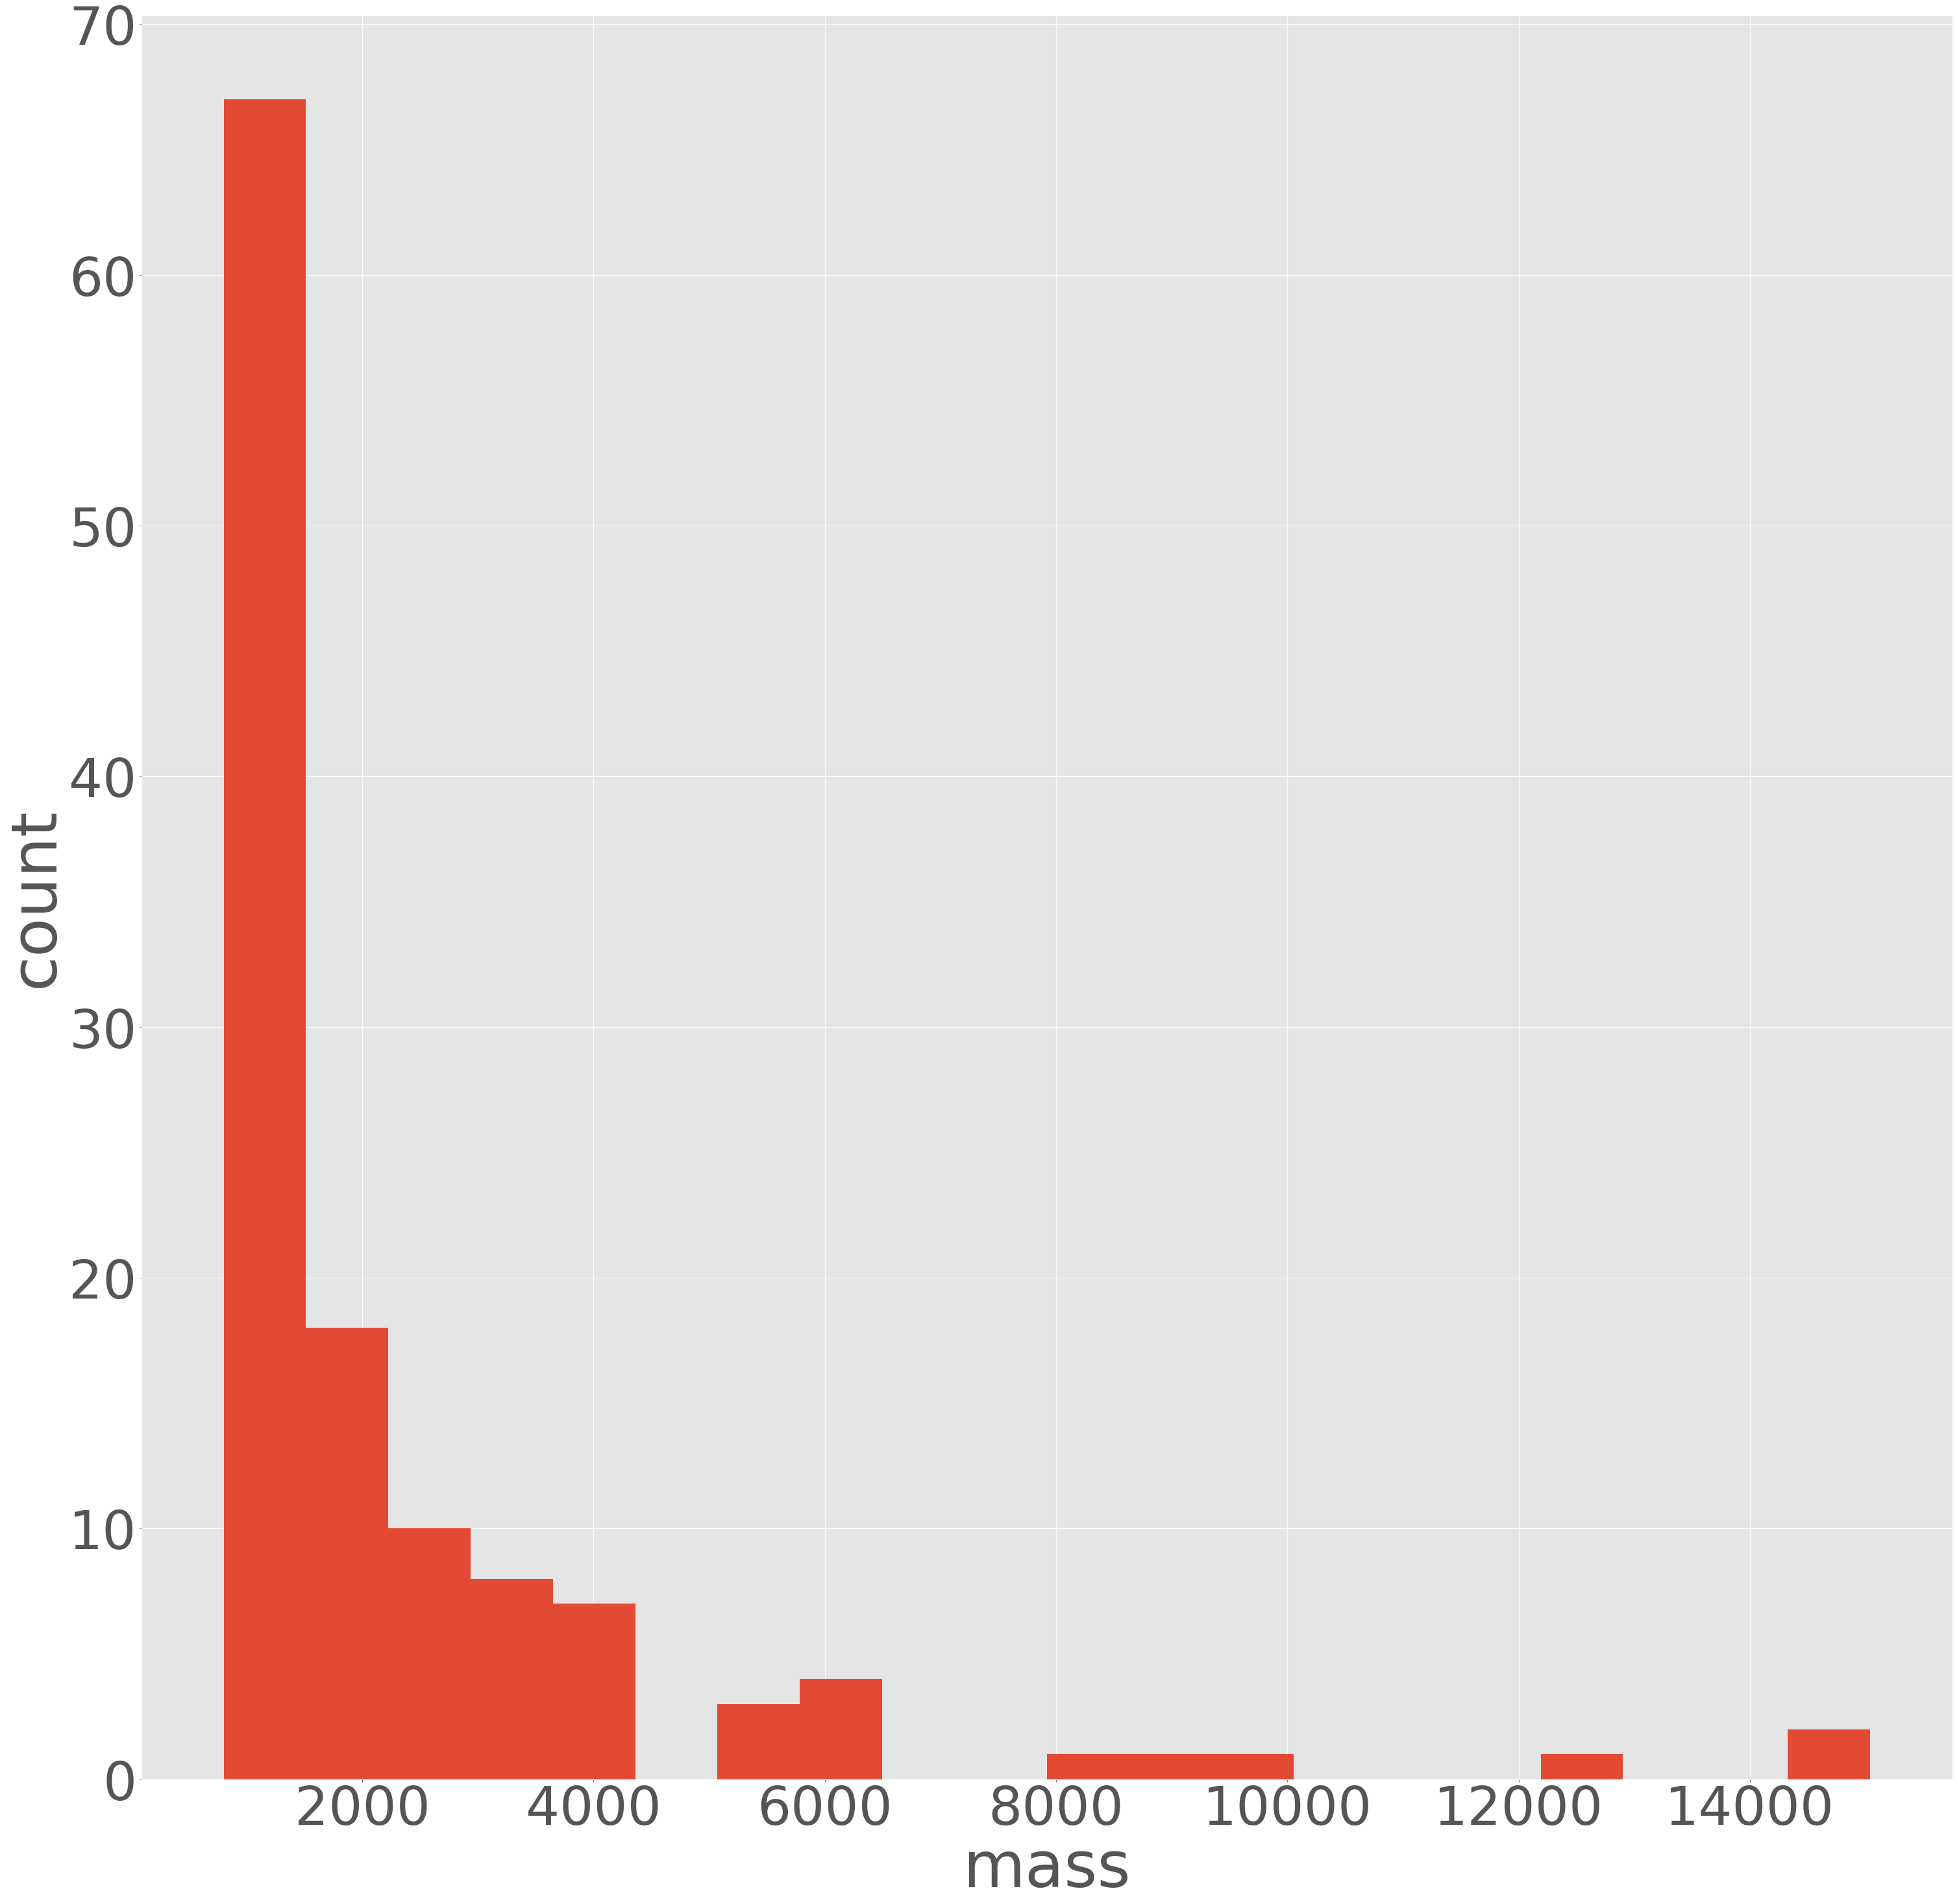

In [55]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [114]:
particles = tp.batch(data[:], 7, minmass=800);

Frame 999: 141 features


In [115]:
tracks = tp.link_df(particles, 5, memory=3)

Frame 999: 141 trajectories present.


In [116]:
filtered_tracks = tp.filter_stubs(tracks, 50)

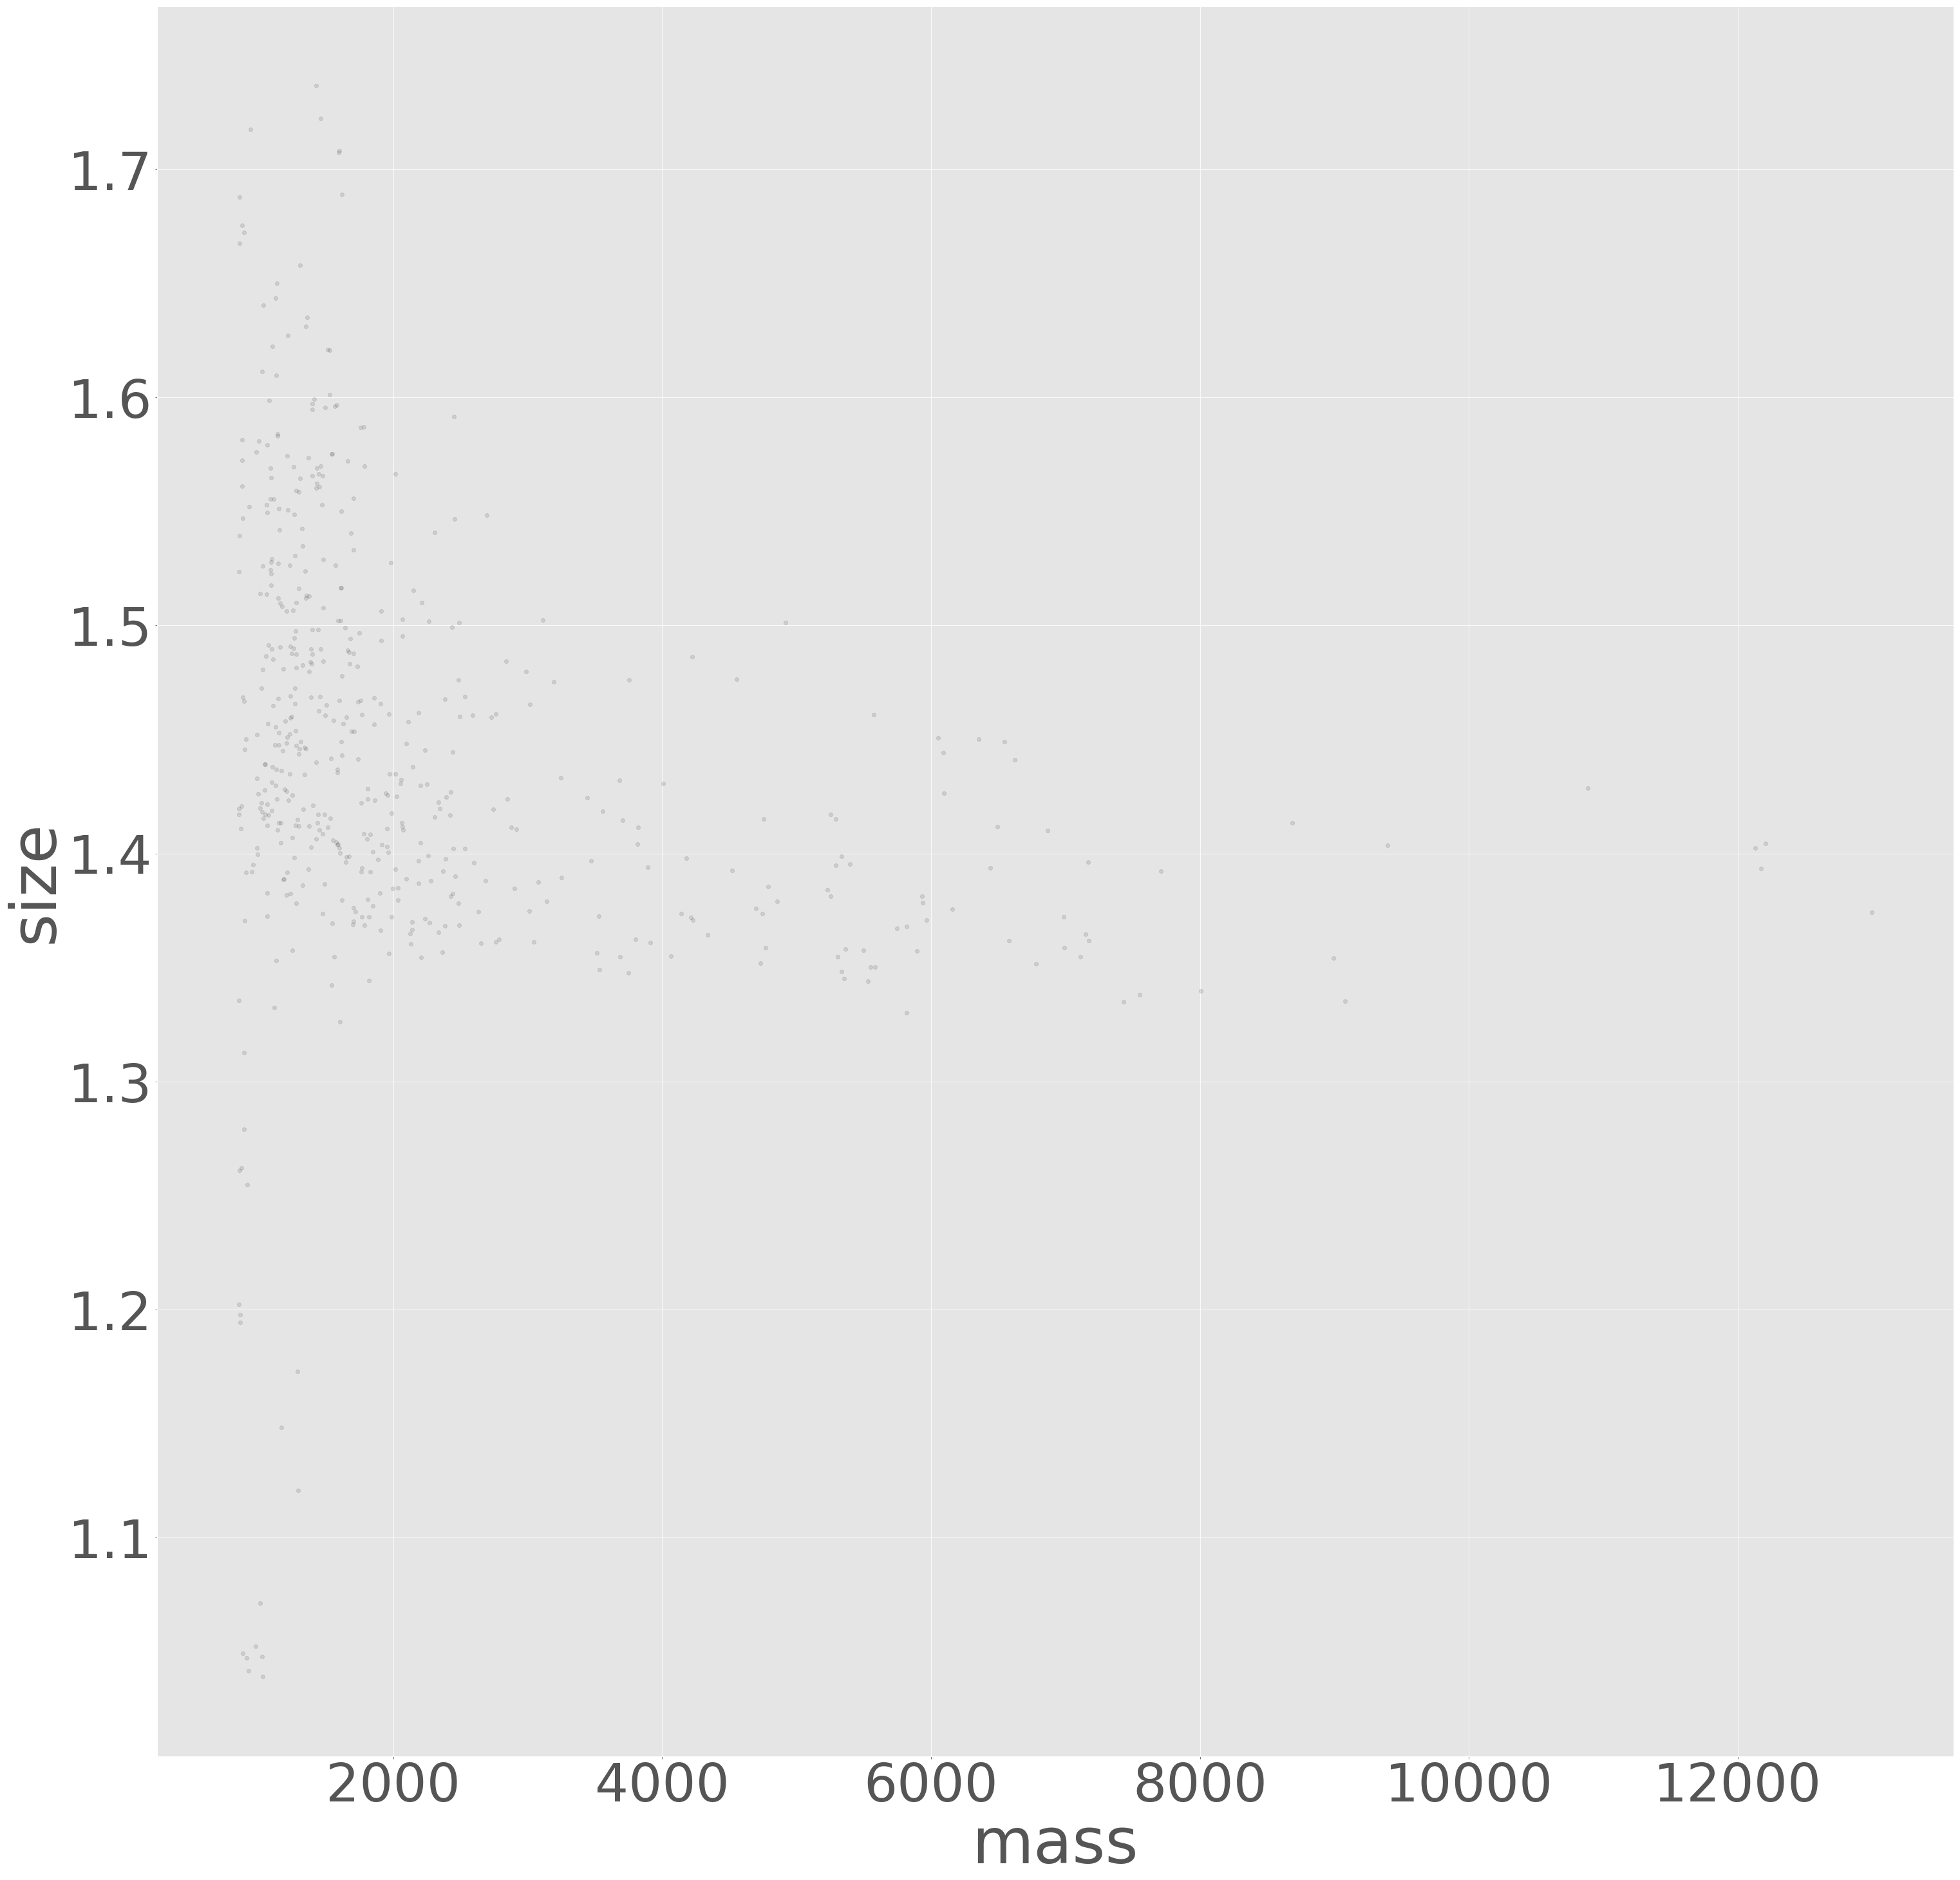

In [59]:
plt.figure()
tp.mass_size(filtered_tracks.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [107]:
drift = tp.compute_drift(filtered_tracks)

C:\ProgramData\Anaconda3\lib\site-packages\trackpy\utils.py:313: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  return df.sort_values(*args, by=by, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\trackpy\motion.py:289: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  dx = f_diff.loc[mask, pos_columns + ['frame']].groupby('frame').mean()


<Figure size 3600x3600 with 0 Axes>

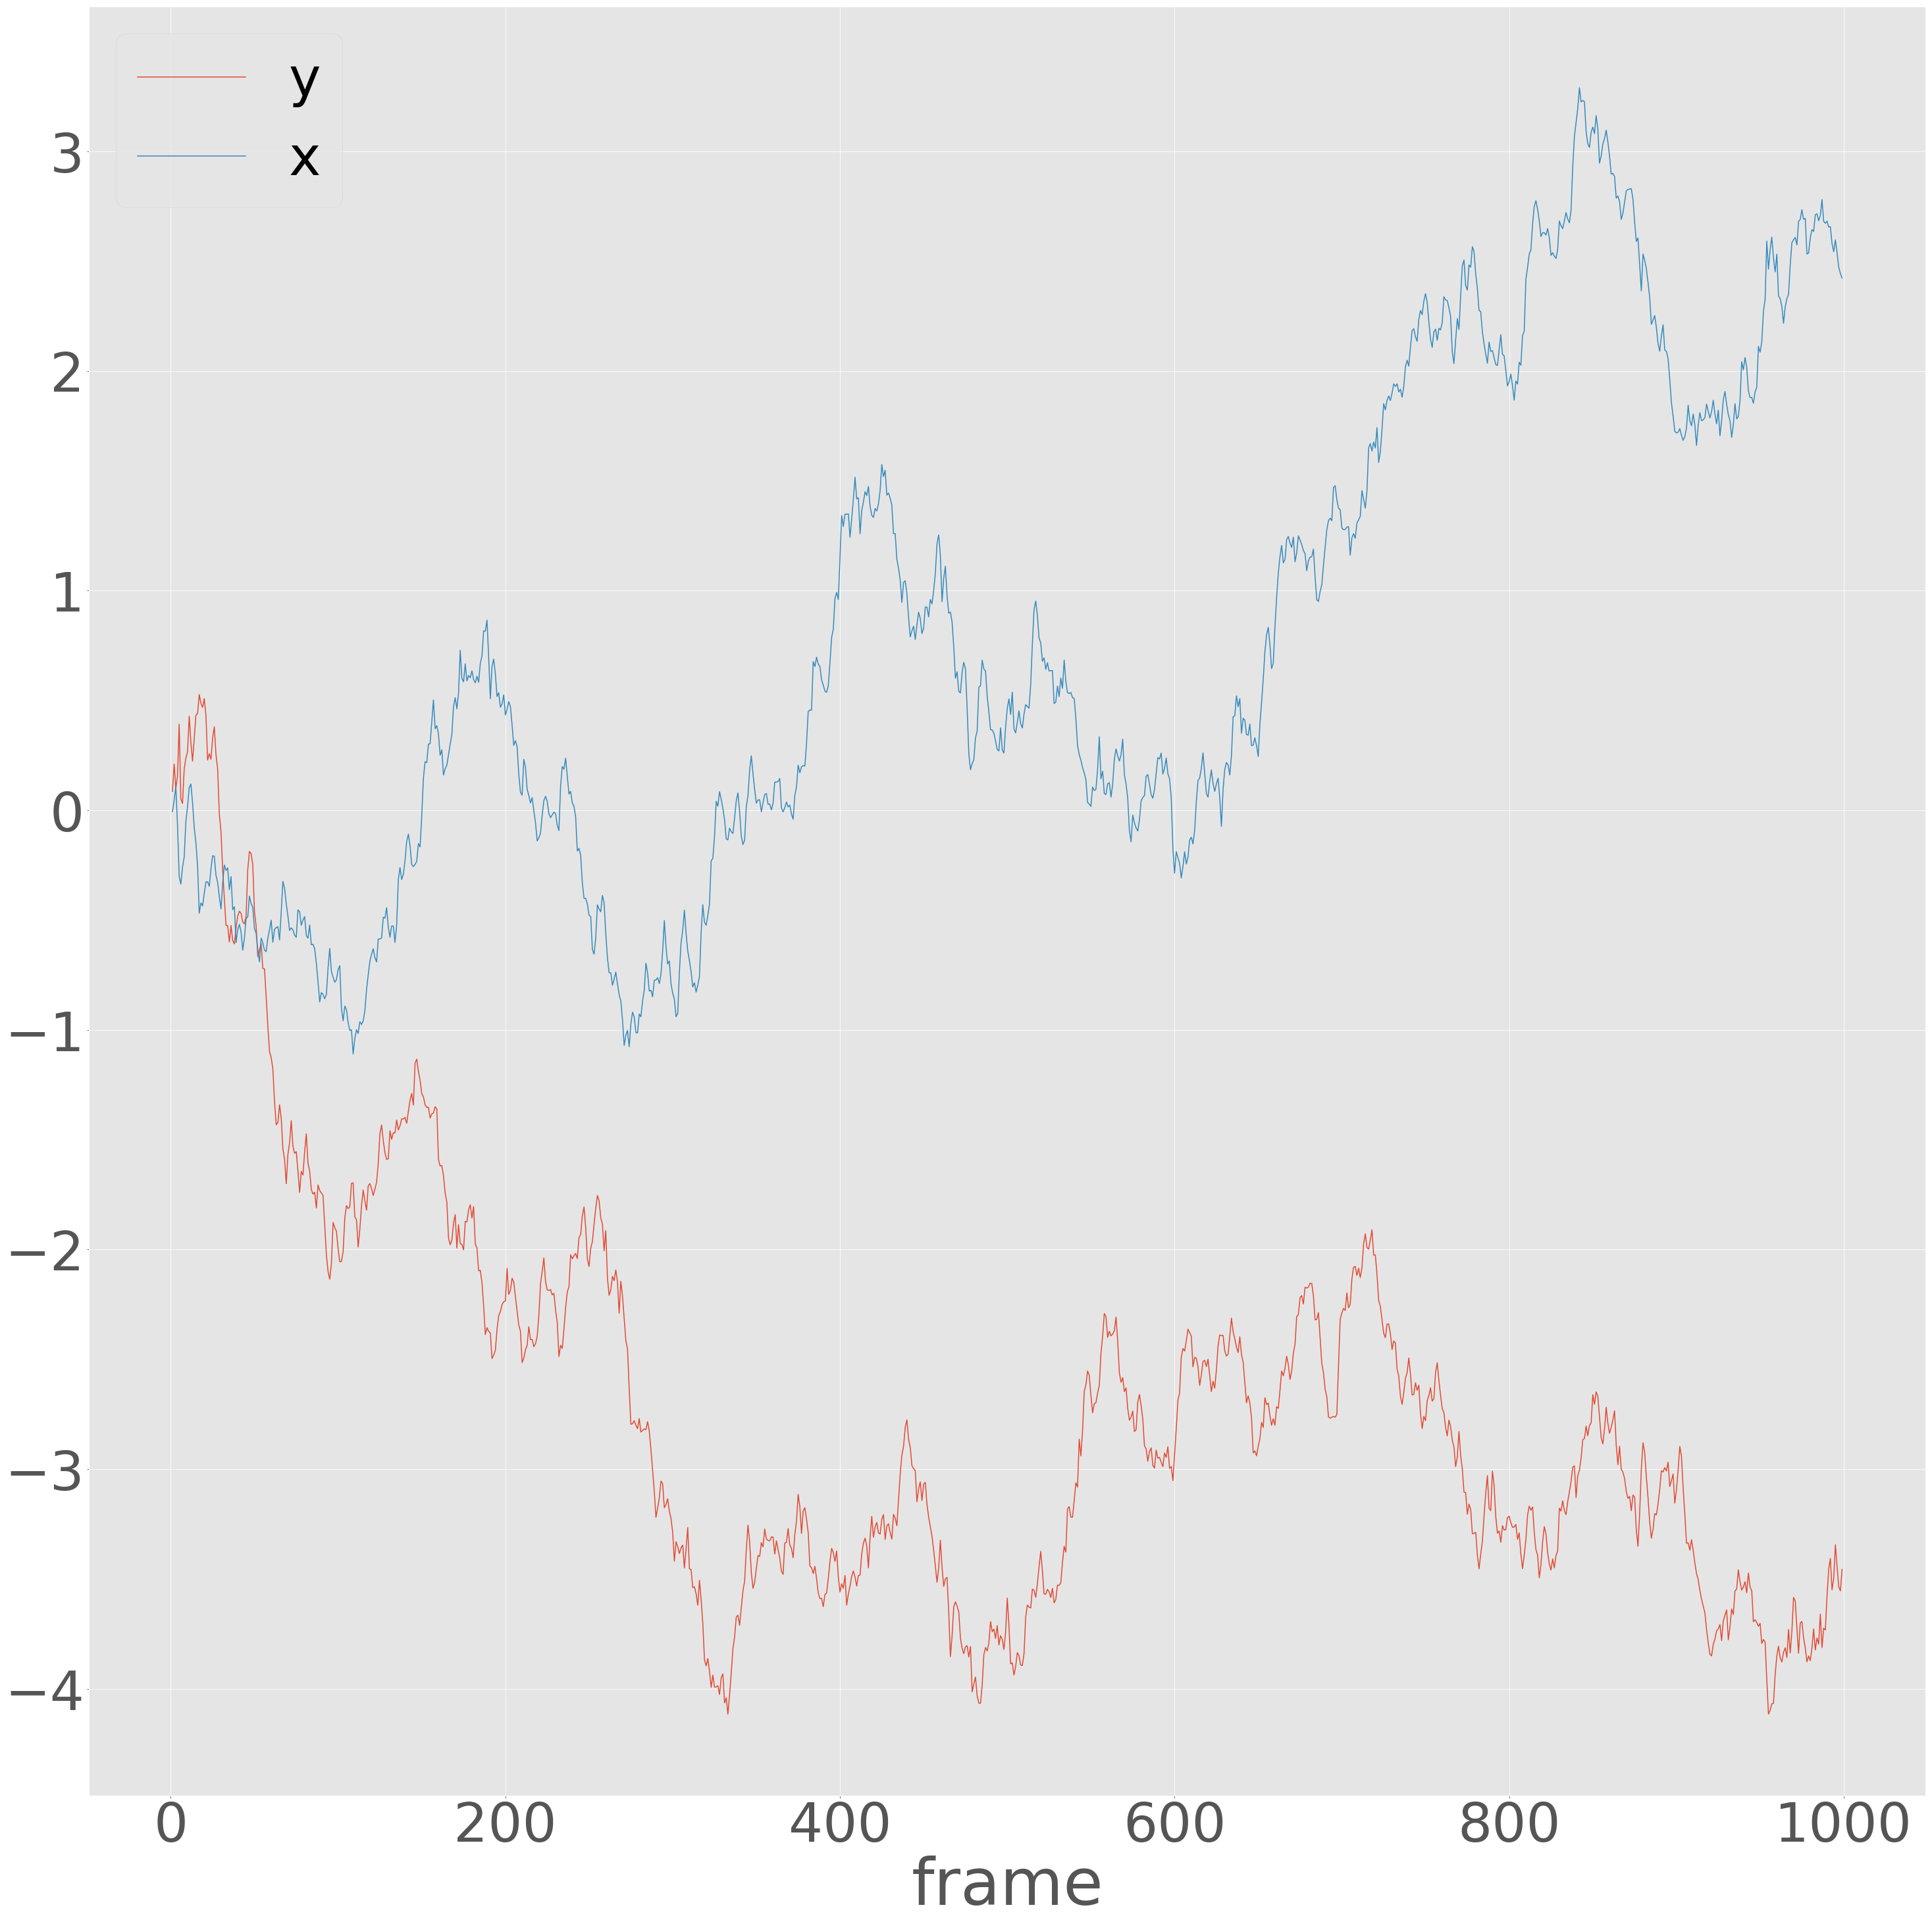

In [84]:
plt.figure()
drift.plot();

In [117]:
tracks_corrected = tp.subtract_drift(filtered_tracks.copy(), drift)

In [118]:
im = tp.imsd(tracks_corrected, 1, 55)

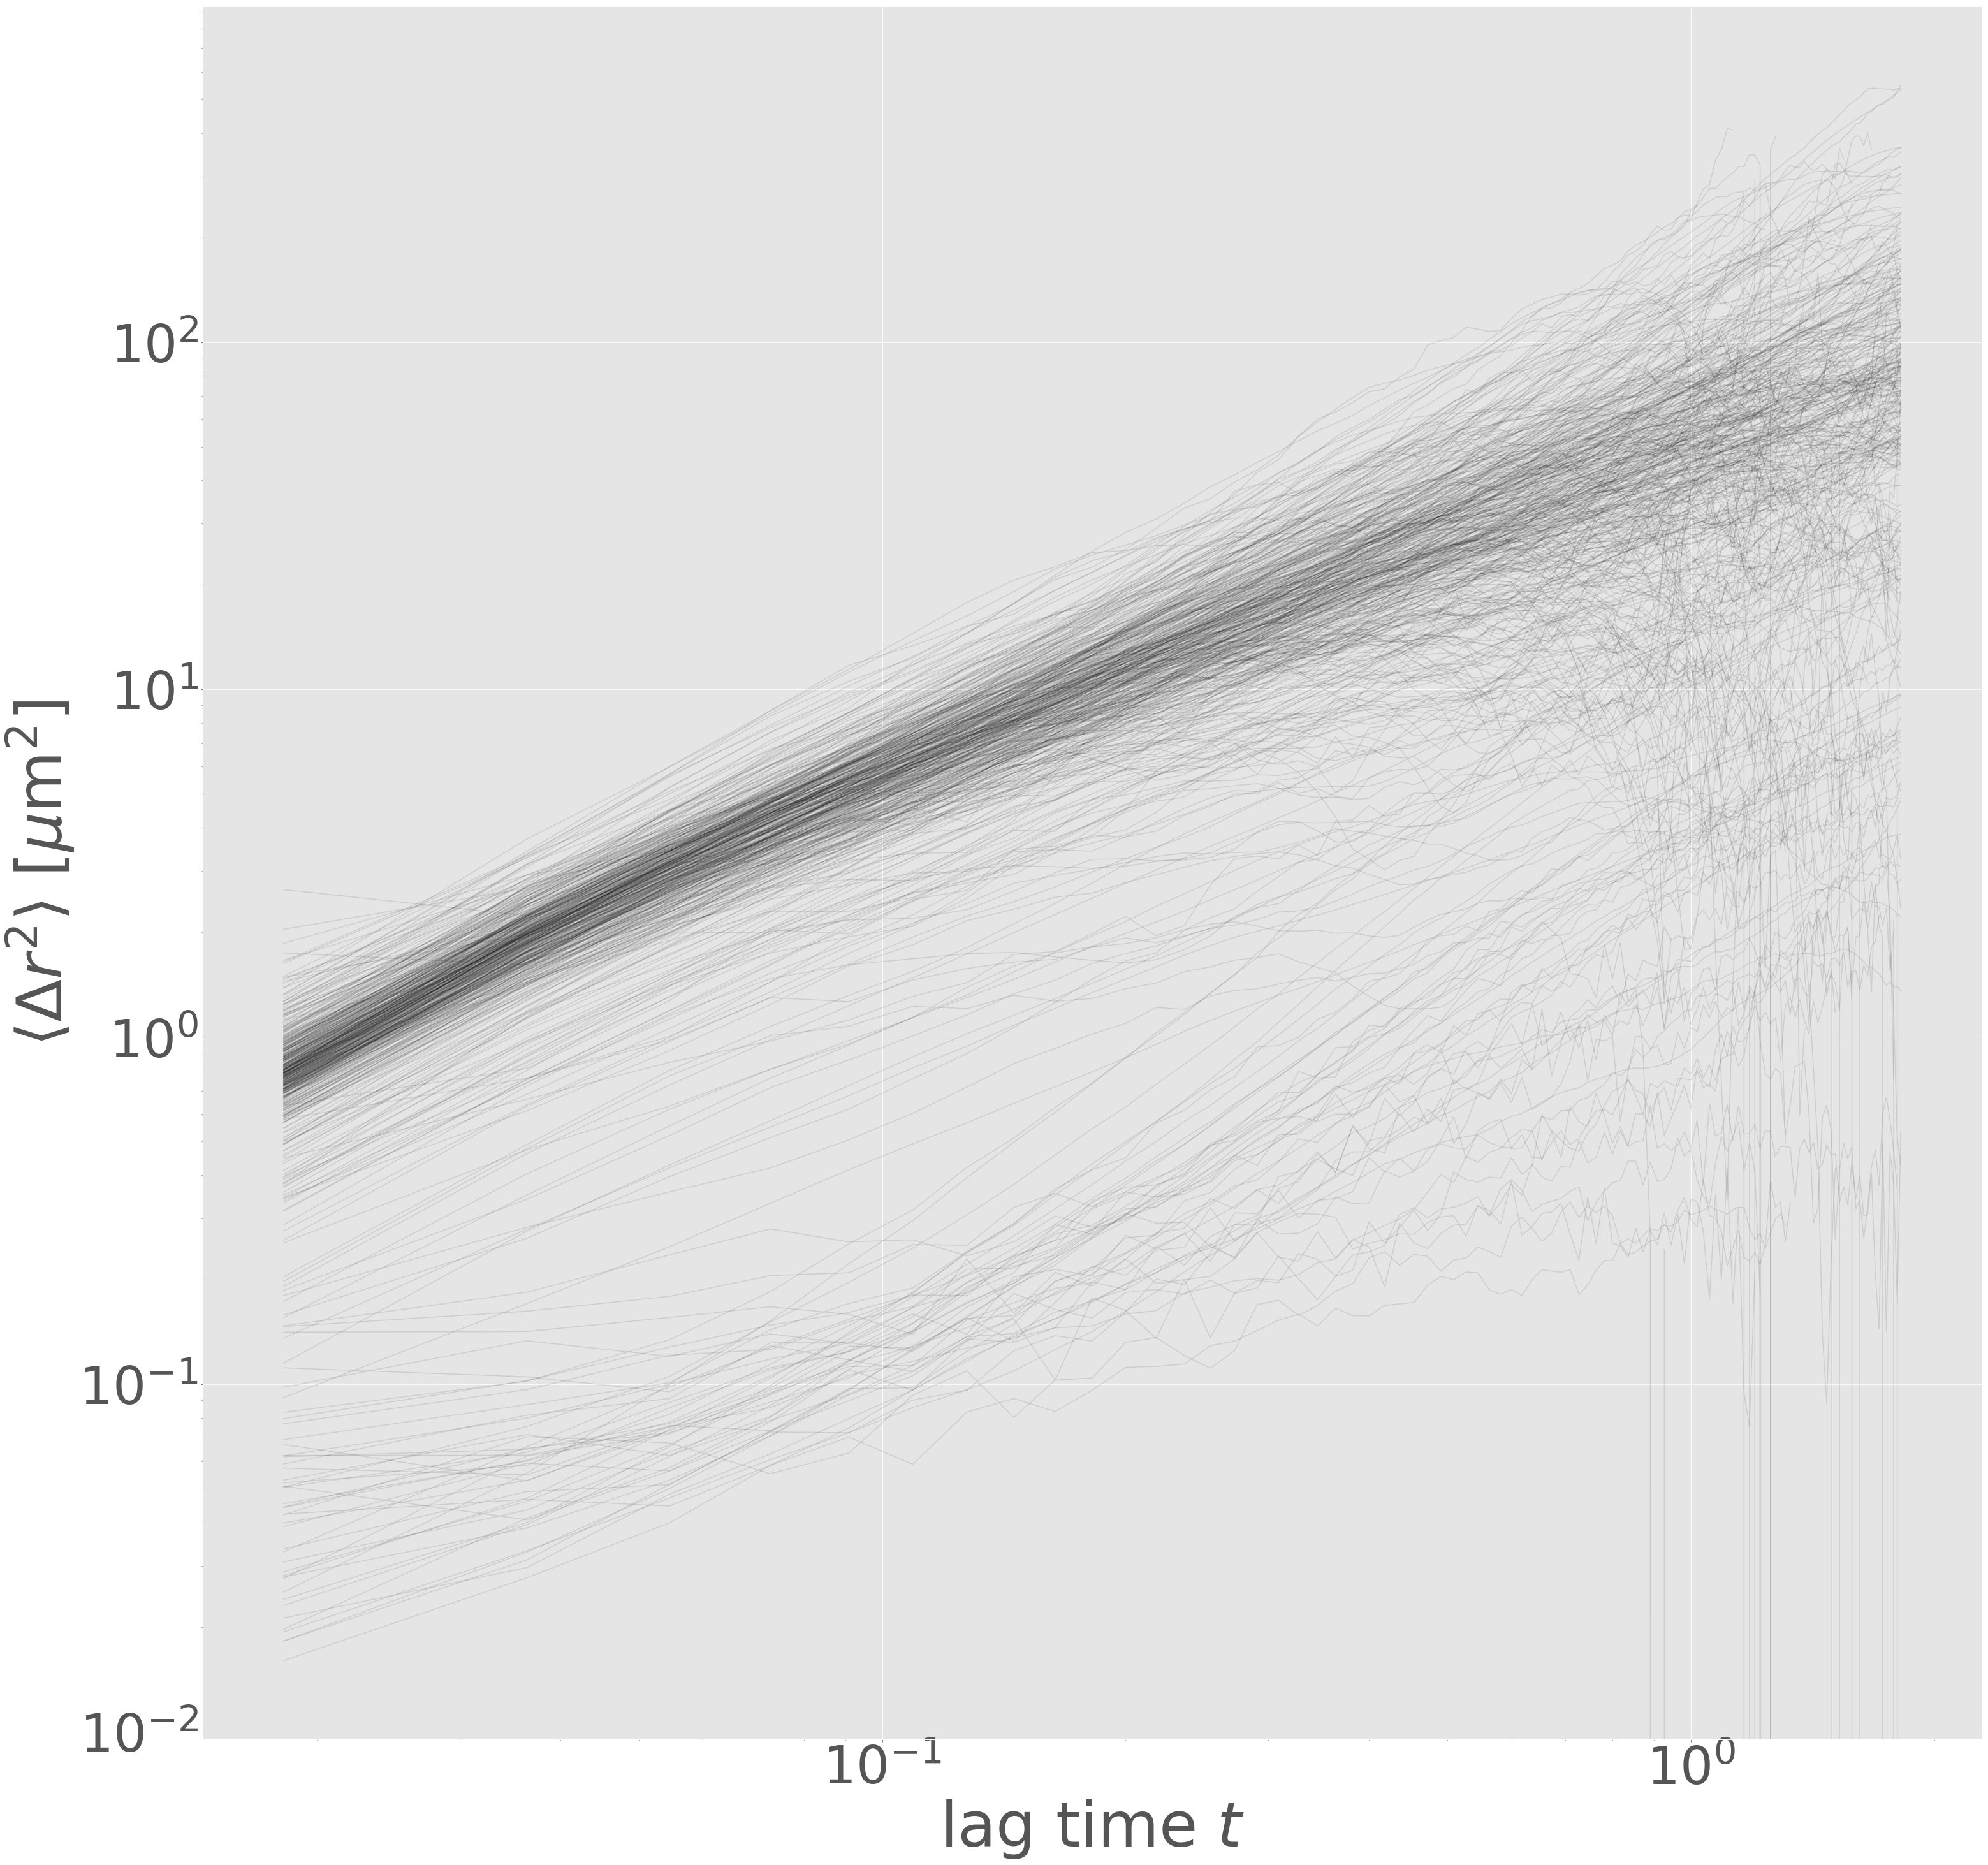

In [64]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [119]:
D = []
for pcle in im:
    try:
        msd = im[pcle]
        D.append(tp.utils.fit_powerlaw(msd, plot=False))
    except ValueError:
        continue

C:\ProgramData\Anaconda3\lib\site-packages\trackpy\utils.py:73: RuntimeWarning: divide by zero encountered in log
  stats.linregress(np.log(x), np.log(y))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3103: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [120]:
dif_coef_1 = []
dif_coef_2 = []
for d in D:
    dif_coef_1.append(float(d['n']))
    dif_coef_2.append(float(d['A']))
dif_coef_1 = np.array(dif_coef_1)
dif_coef_1 = dif_coef_1[~np.isnan(dif_coef_1)]
dif_coef_2 = np.array(dif_coef_2)
dif_coef_2 = dif_coef_2[~np.isnan(dif_coef_2)]

Text(0.5,1,'30nm')

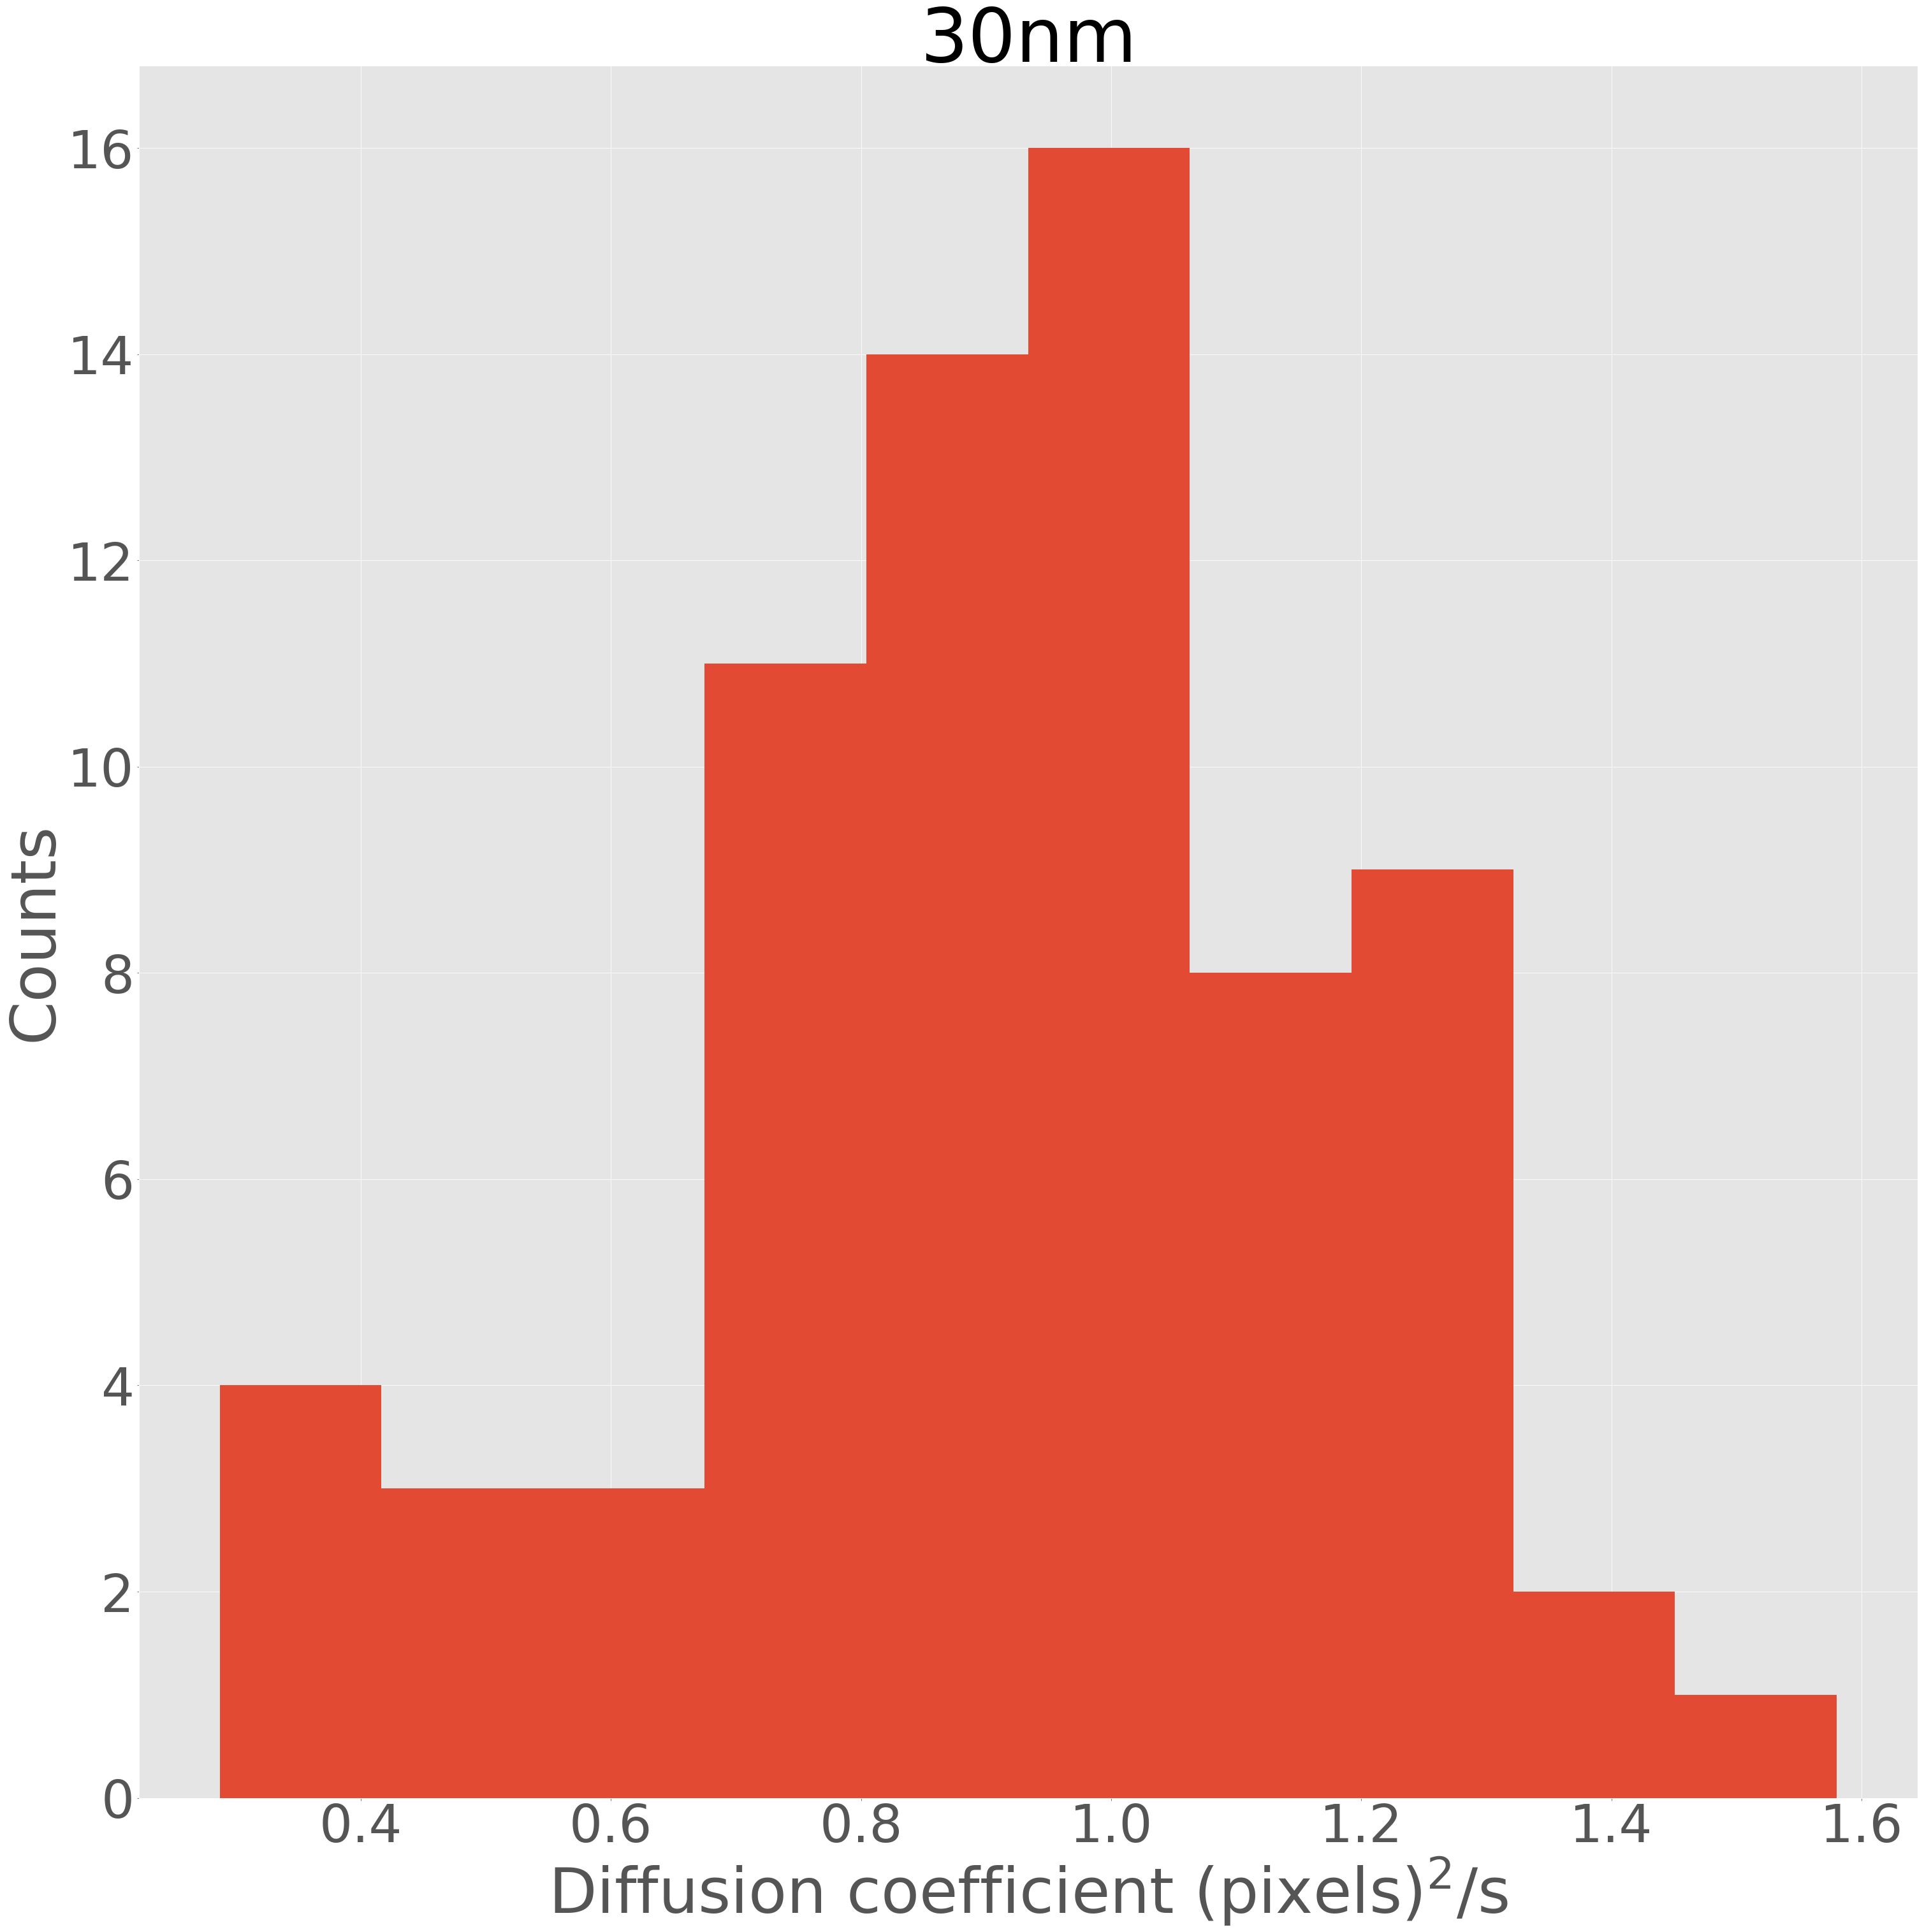

In [101]:
plt.hist(dif_coef_1)
plt.xlabel('Diffusion coefficient (pixels)$^2$/s')
plt.ylabel('Counts')
plt.title('30nm')

In [121]:
D_30_40 = dif_coef_1

(array([56., 70., 87., 51., 18.,  7.,  8.,  2.,  3.,  2.]),
 array([  0.3896607 ,  20.48699846,  40.58433622,  60.68167399,
         80.77901175, 100.87634951, 120.97368727, 141.07102504,
        161.1683628 , 181.26570056, 201.36303833]),
 <a list of 10 Patch objects>)

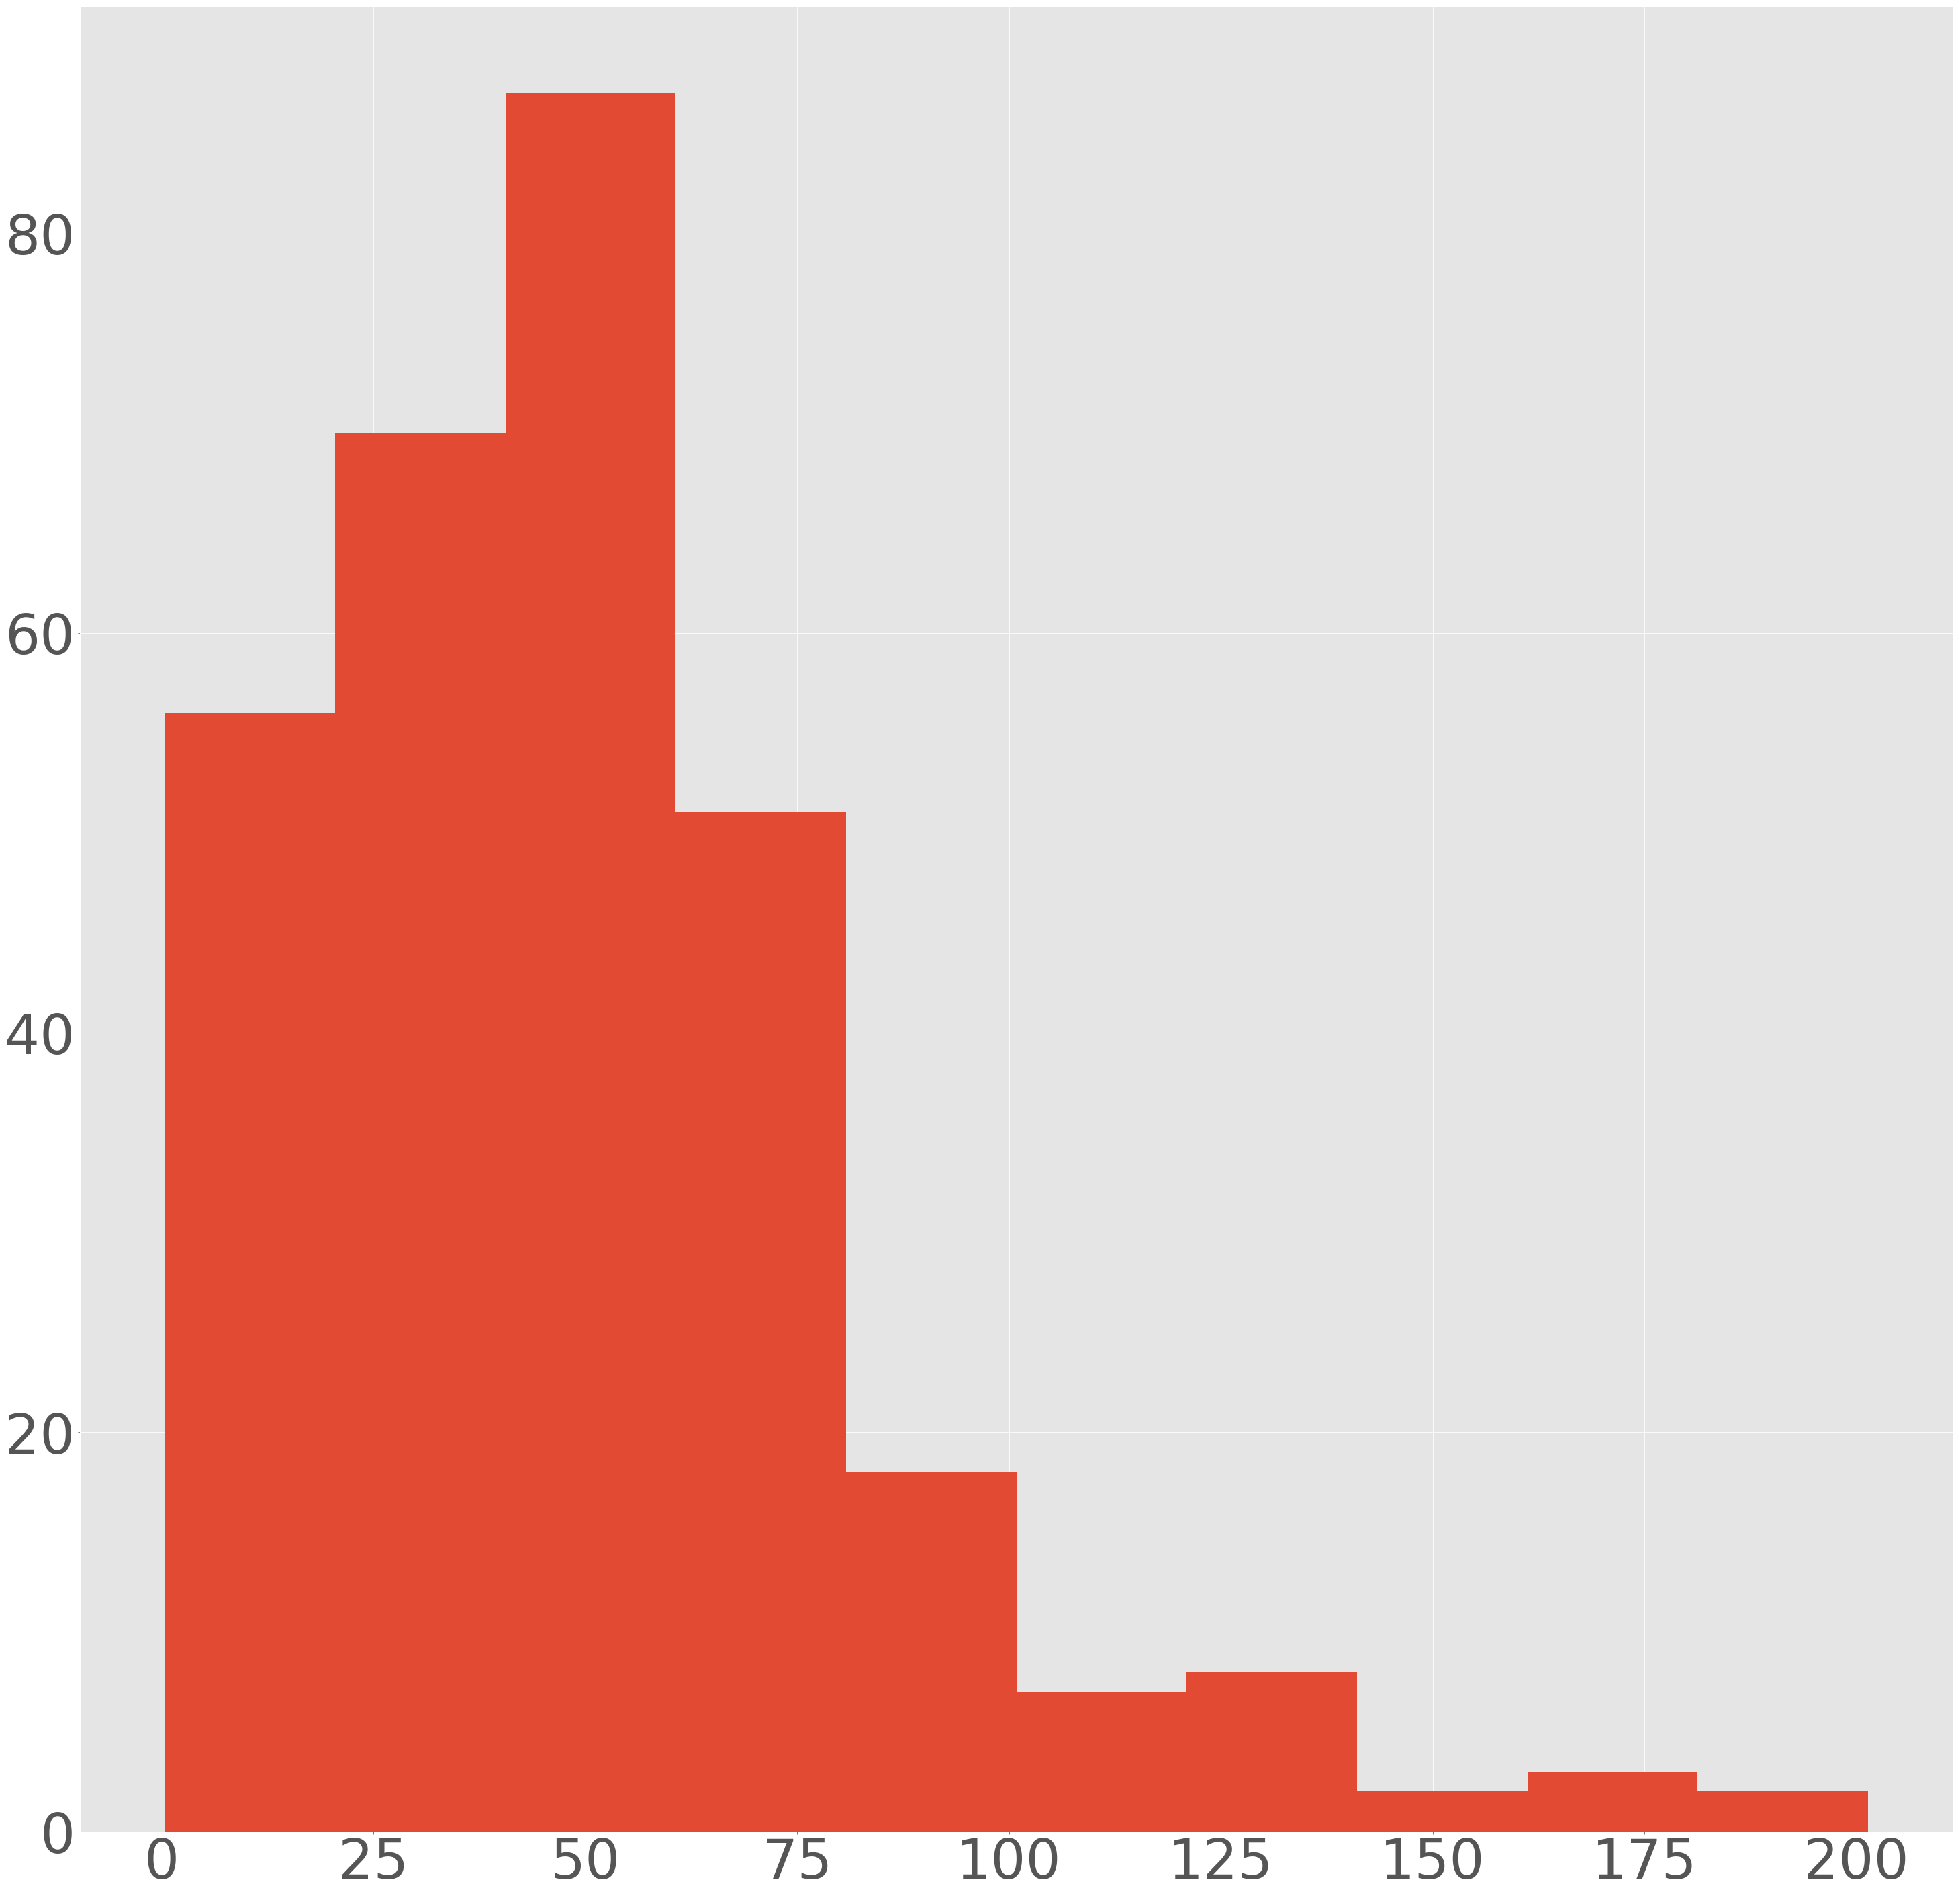

In [68]:
plt.hist(dif_coef_2)

In [69]:
pcle_1 = filtered_tracks[filtered_tracks['particle']==1]

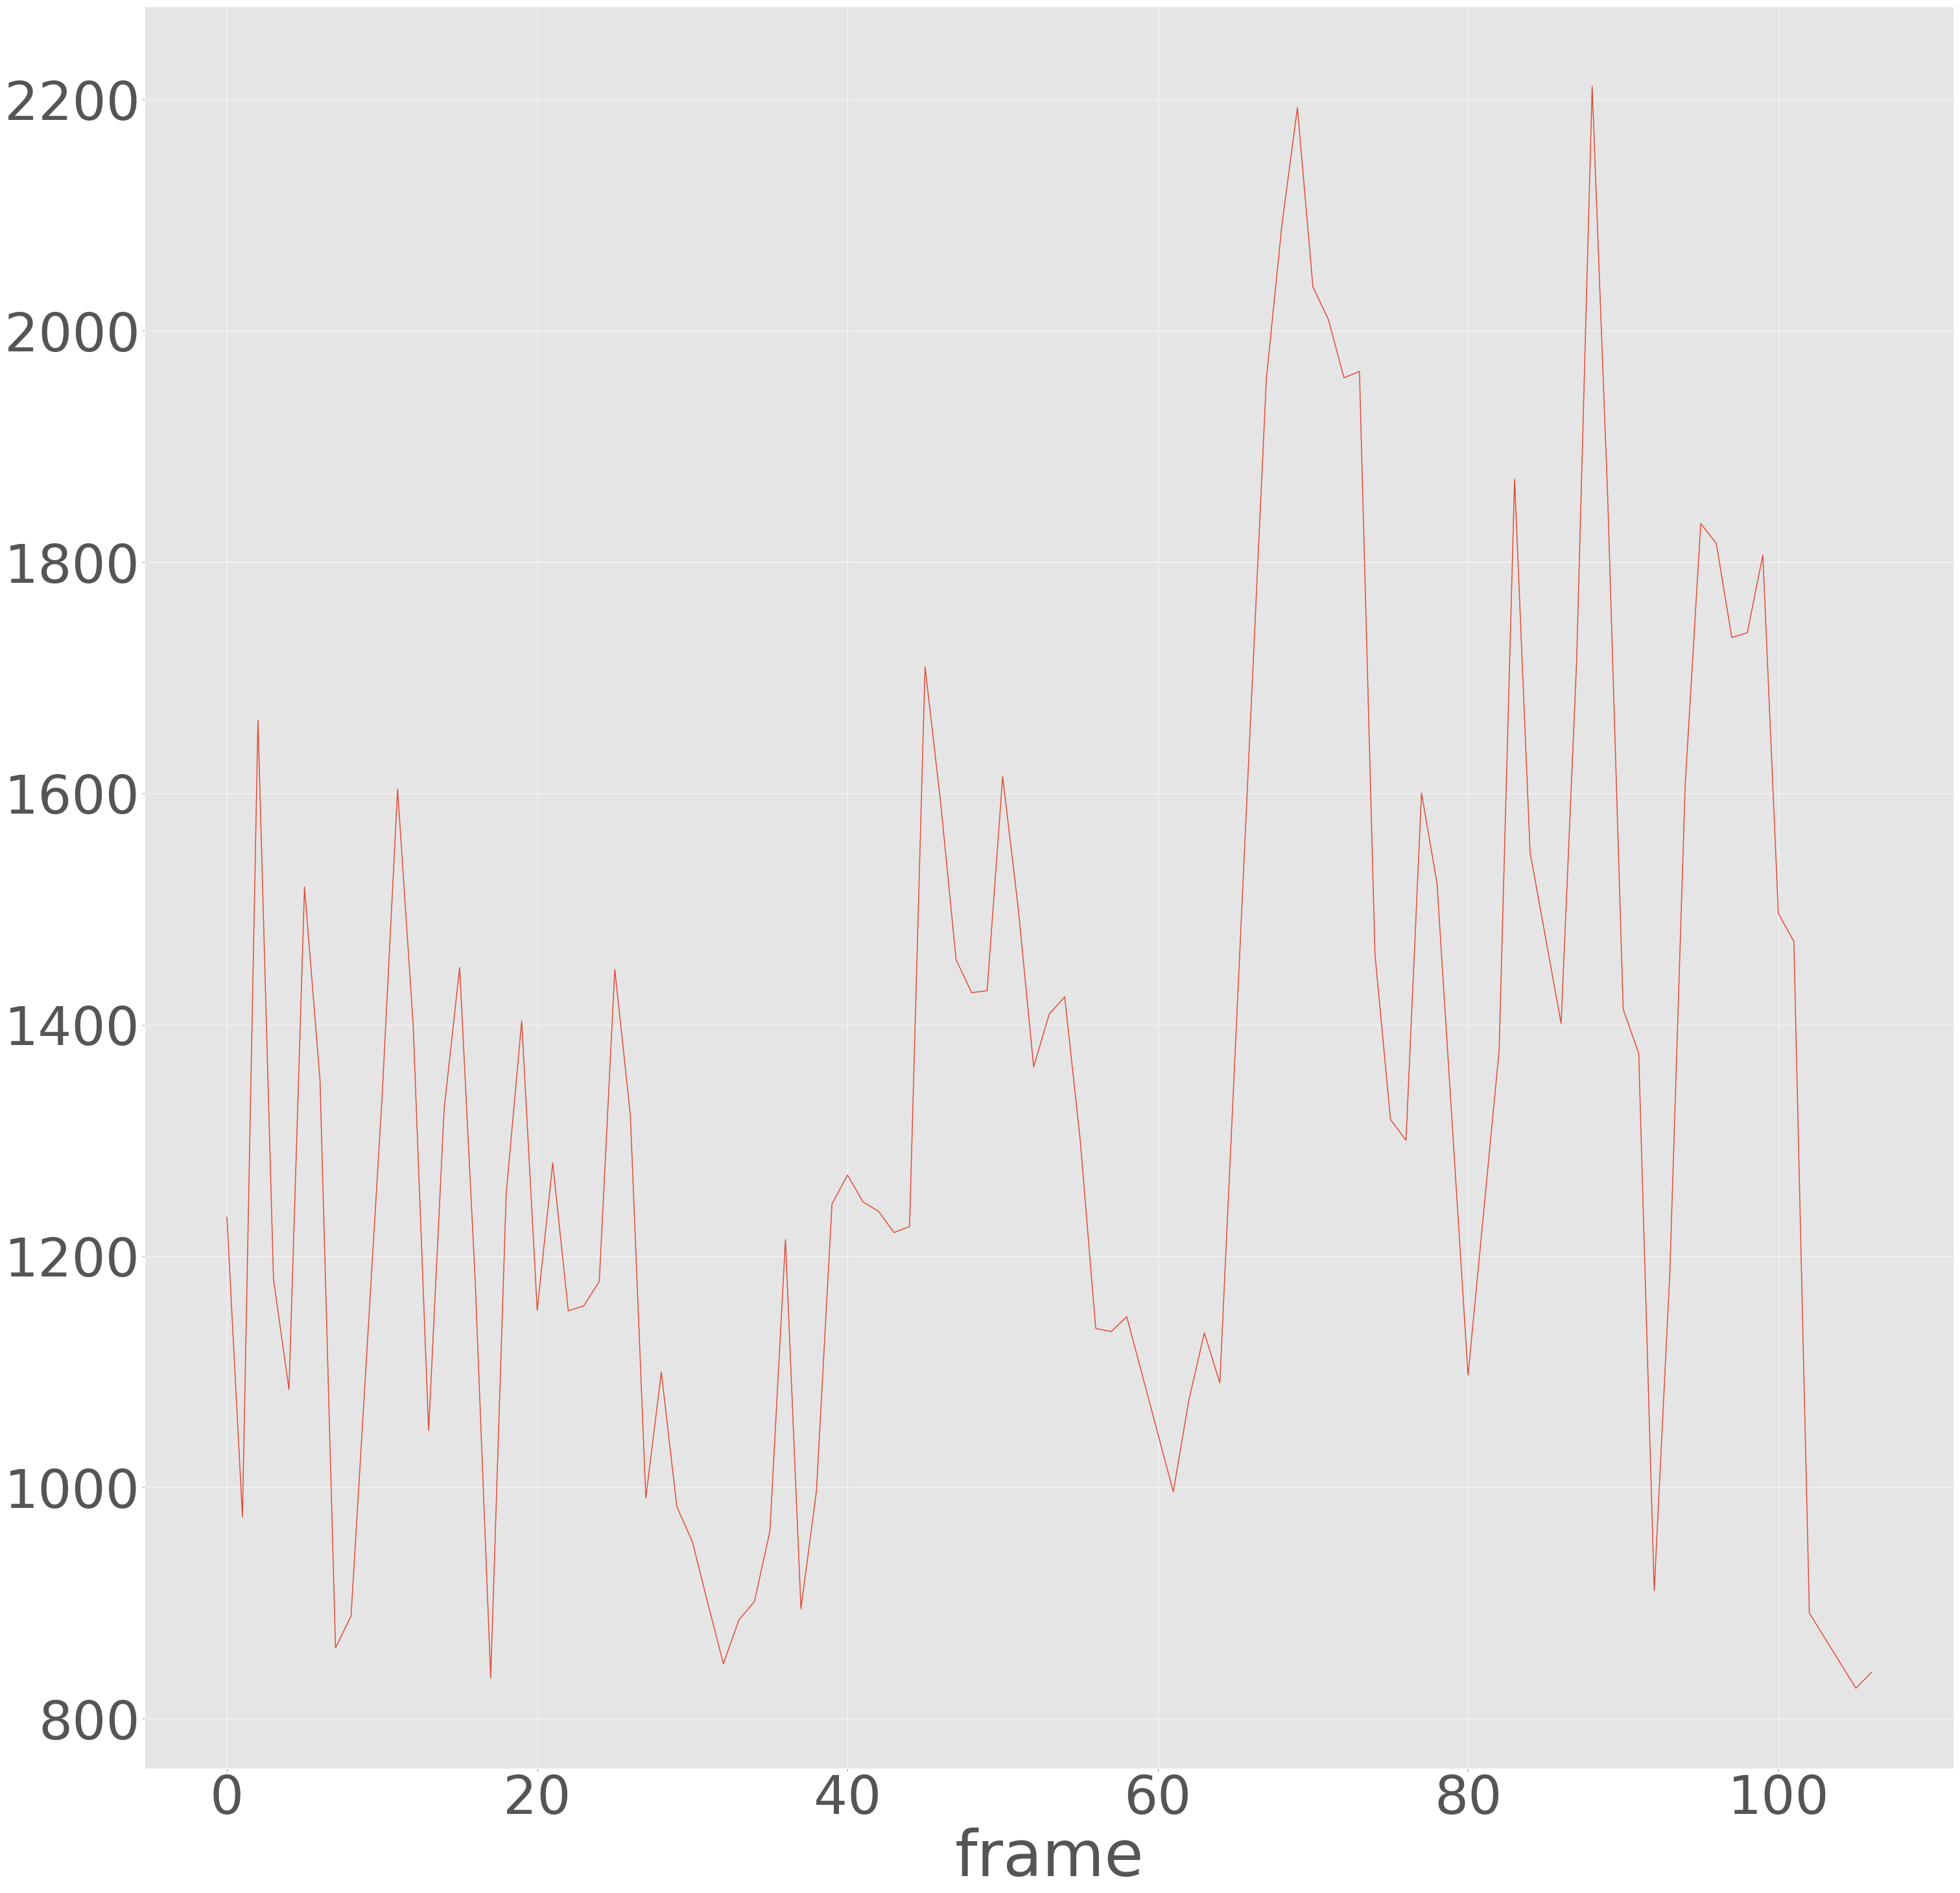

In [70]:
pcle = 5
filtered_tracks[filtered_tracks['particle']==pcle]['mass'].plot()

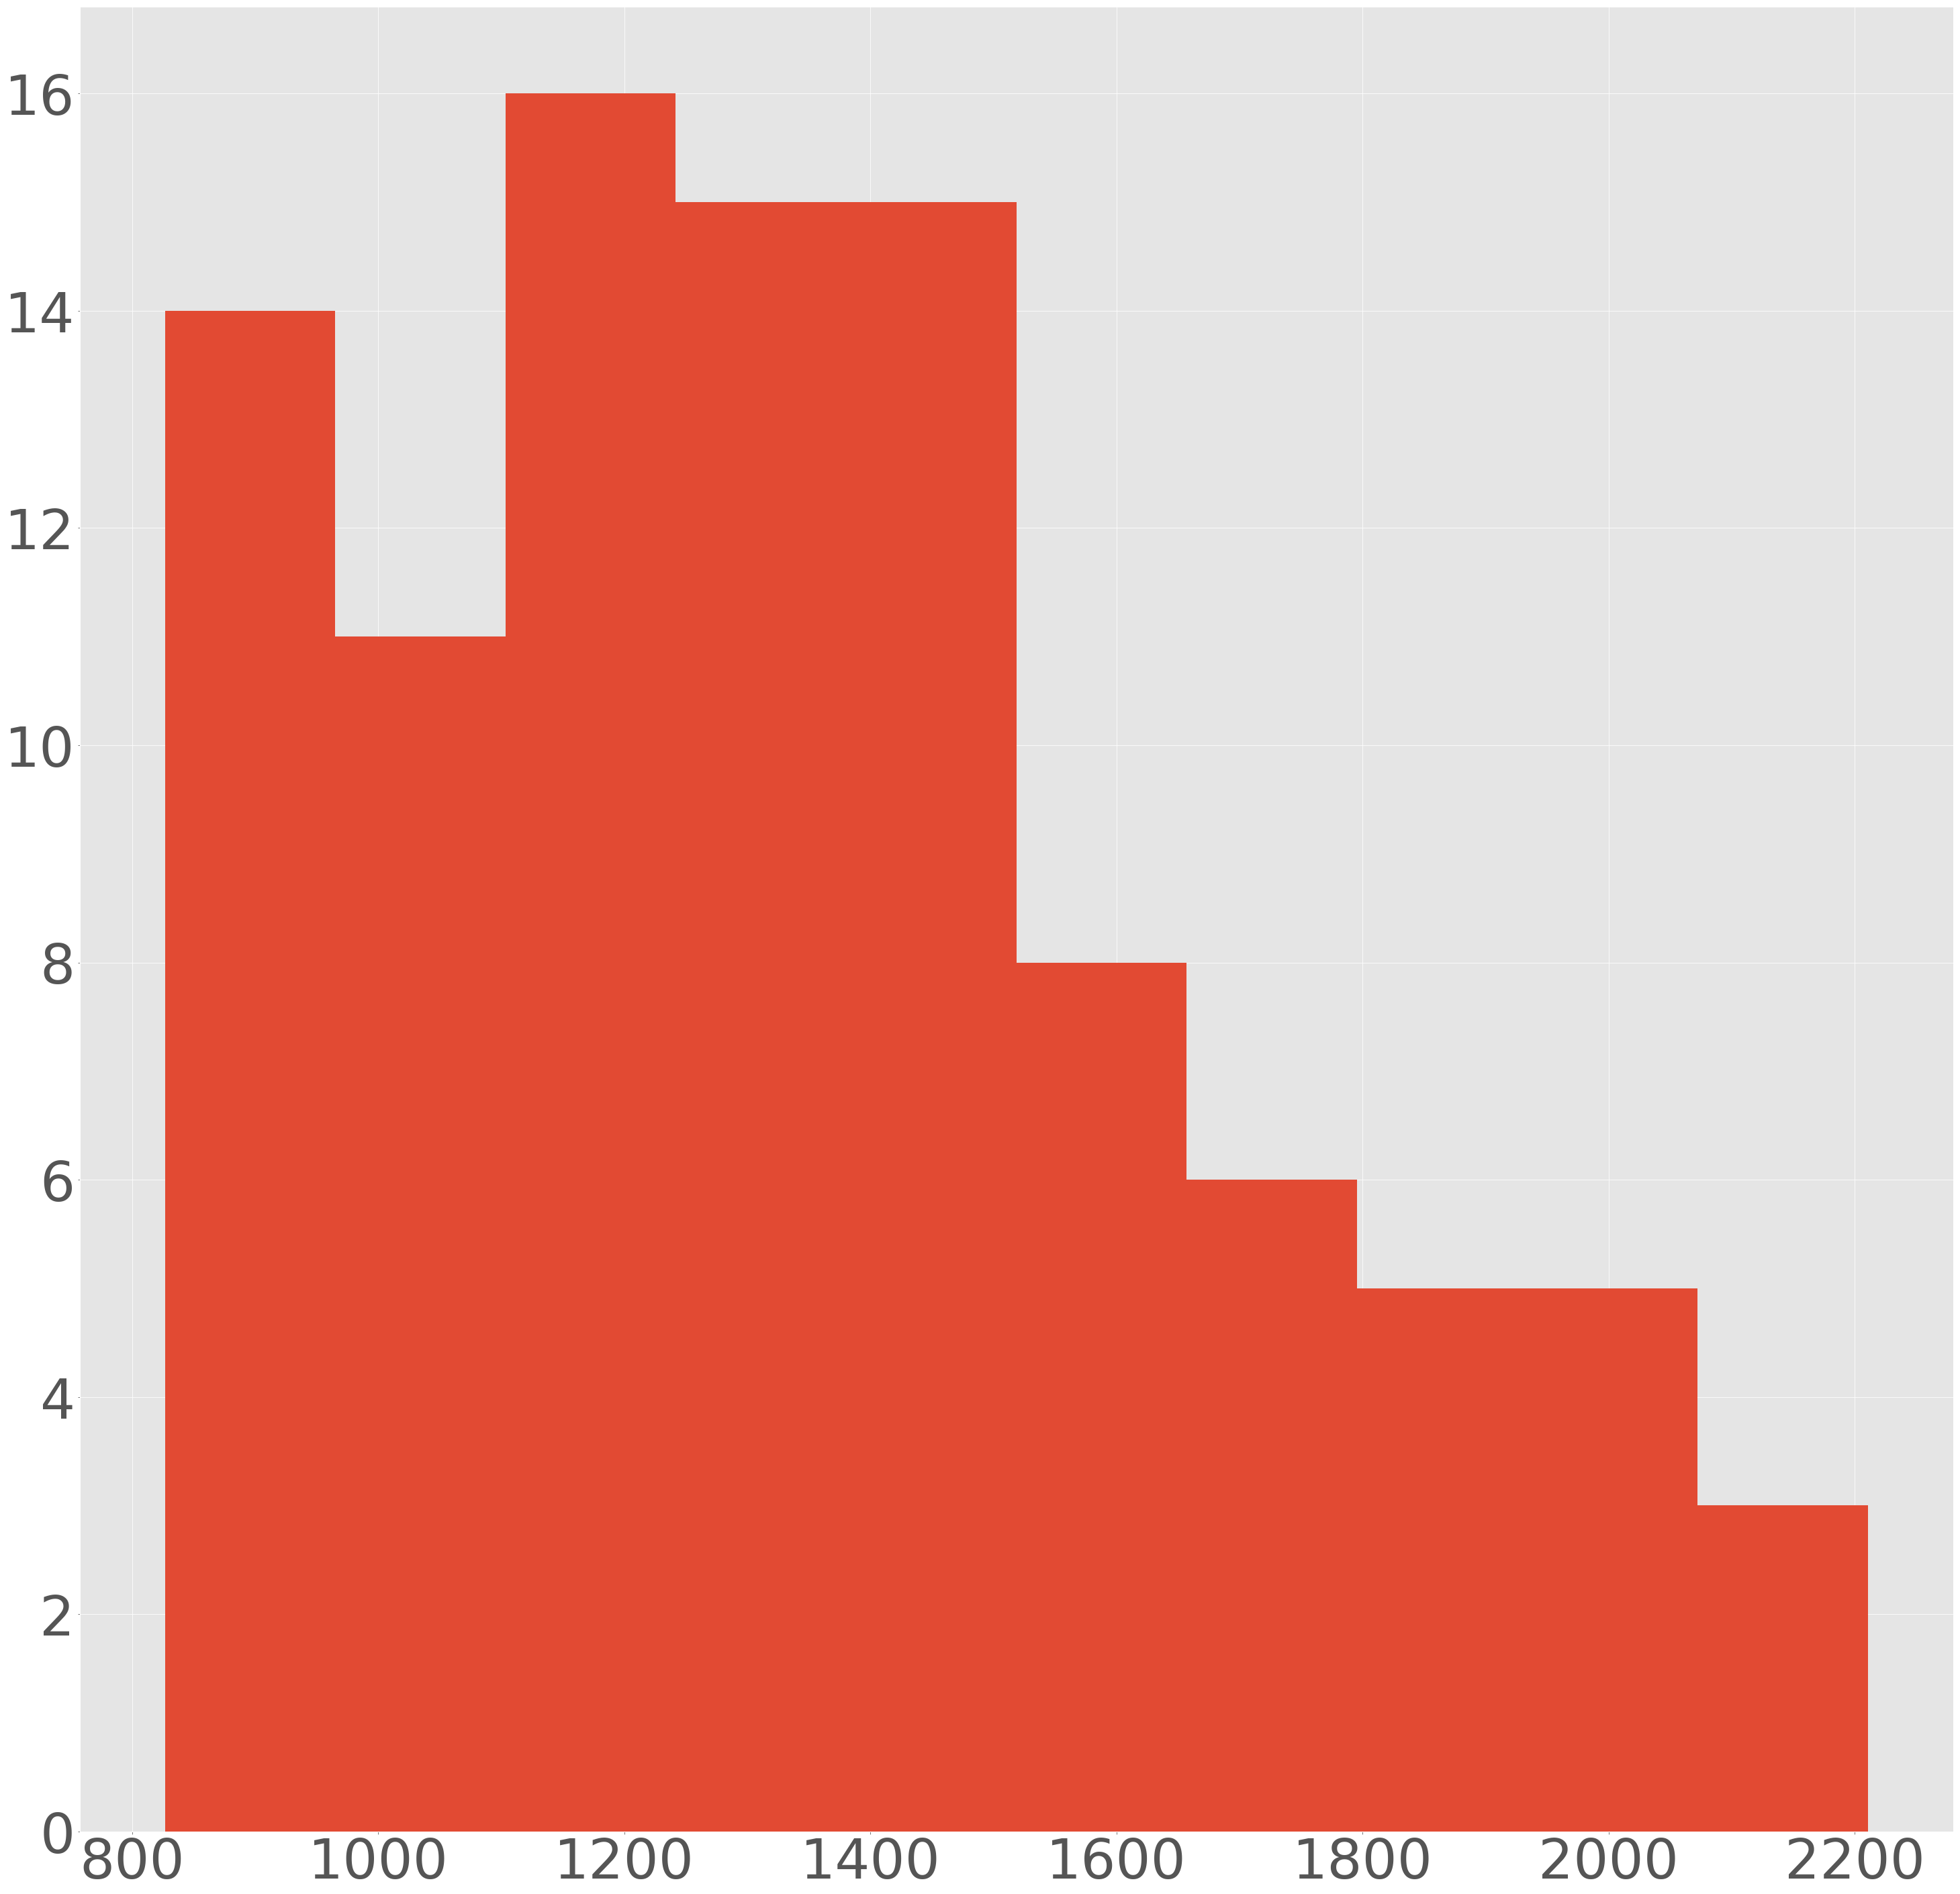

In [71]:
filtered_tracks[filtered_tracks['particle']==pcle]['mass'].hist()

In [72]:
masses = filtered_tracks.groupby(by='particle', axis=0)['mass'].mean()

(500, 5000)

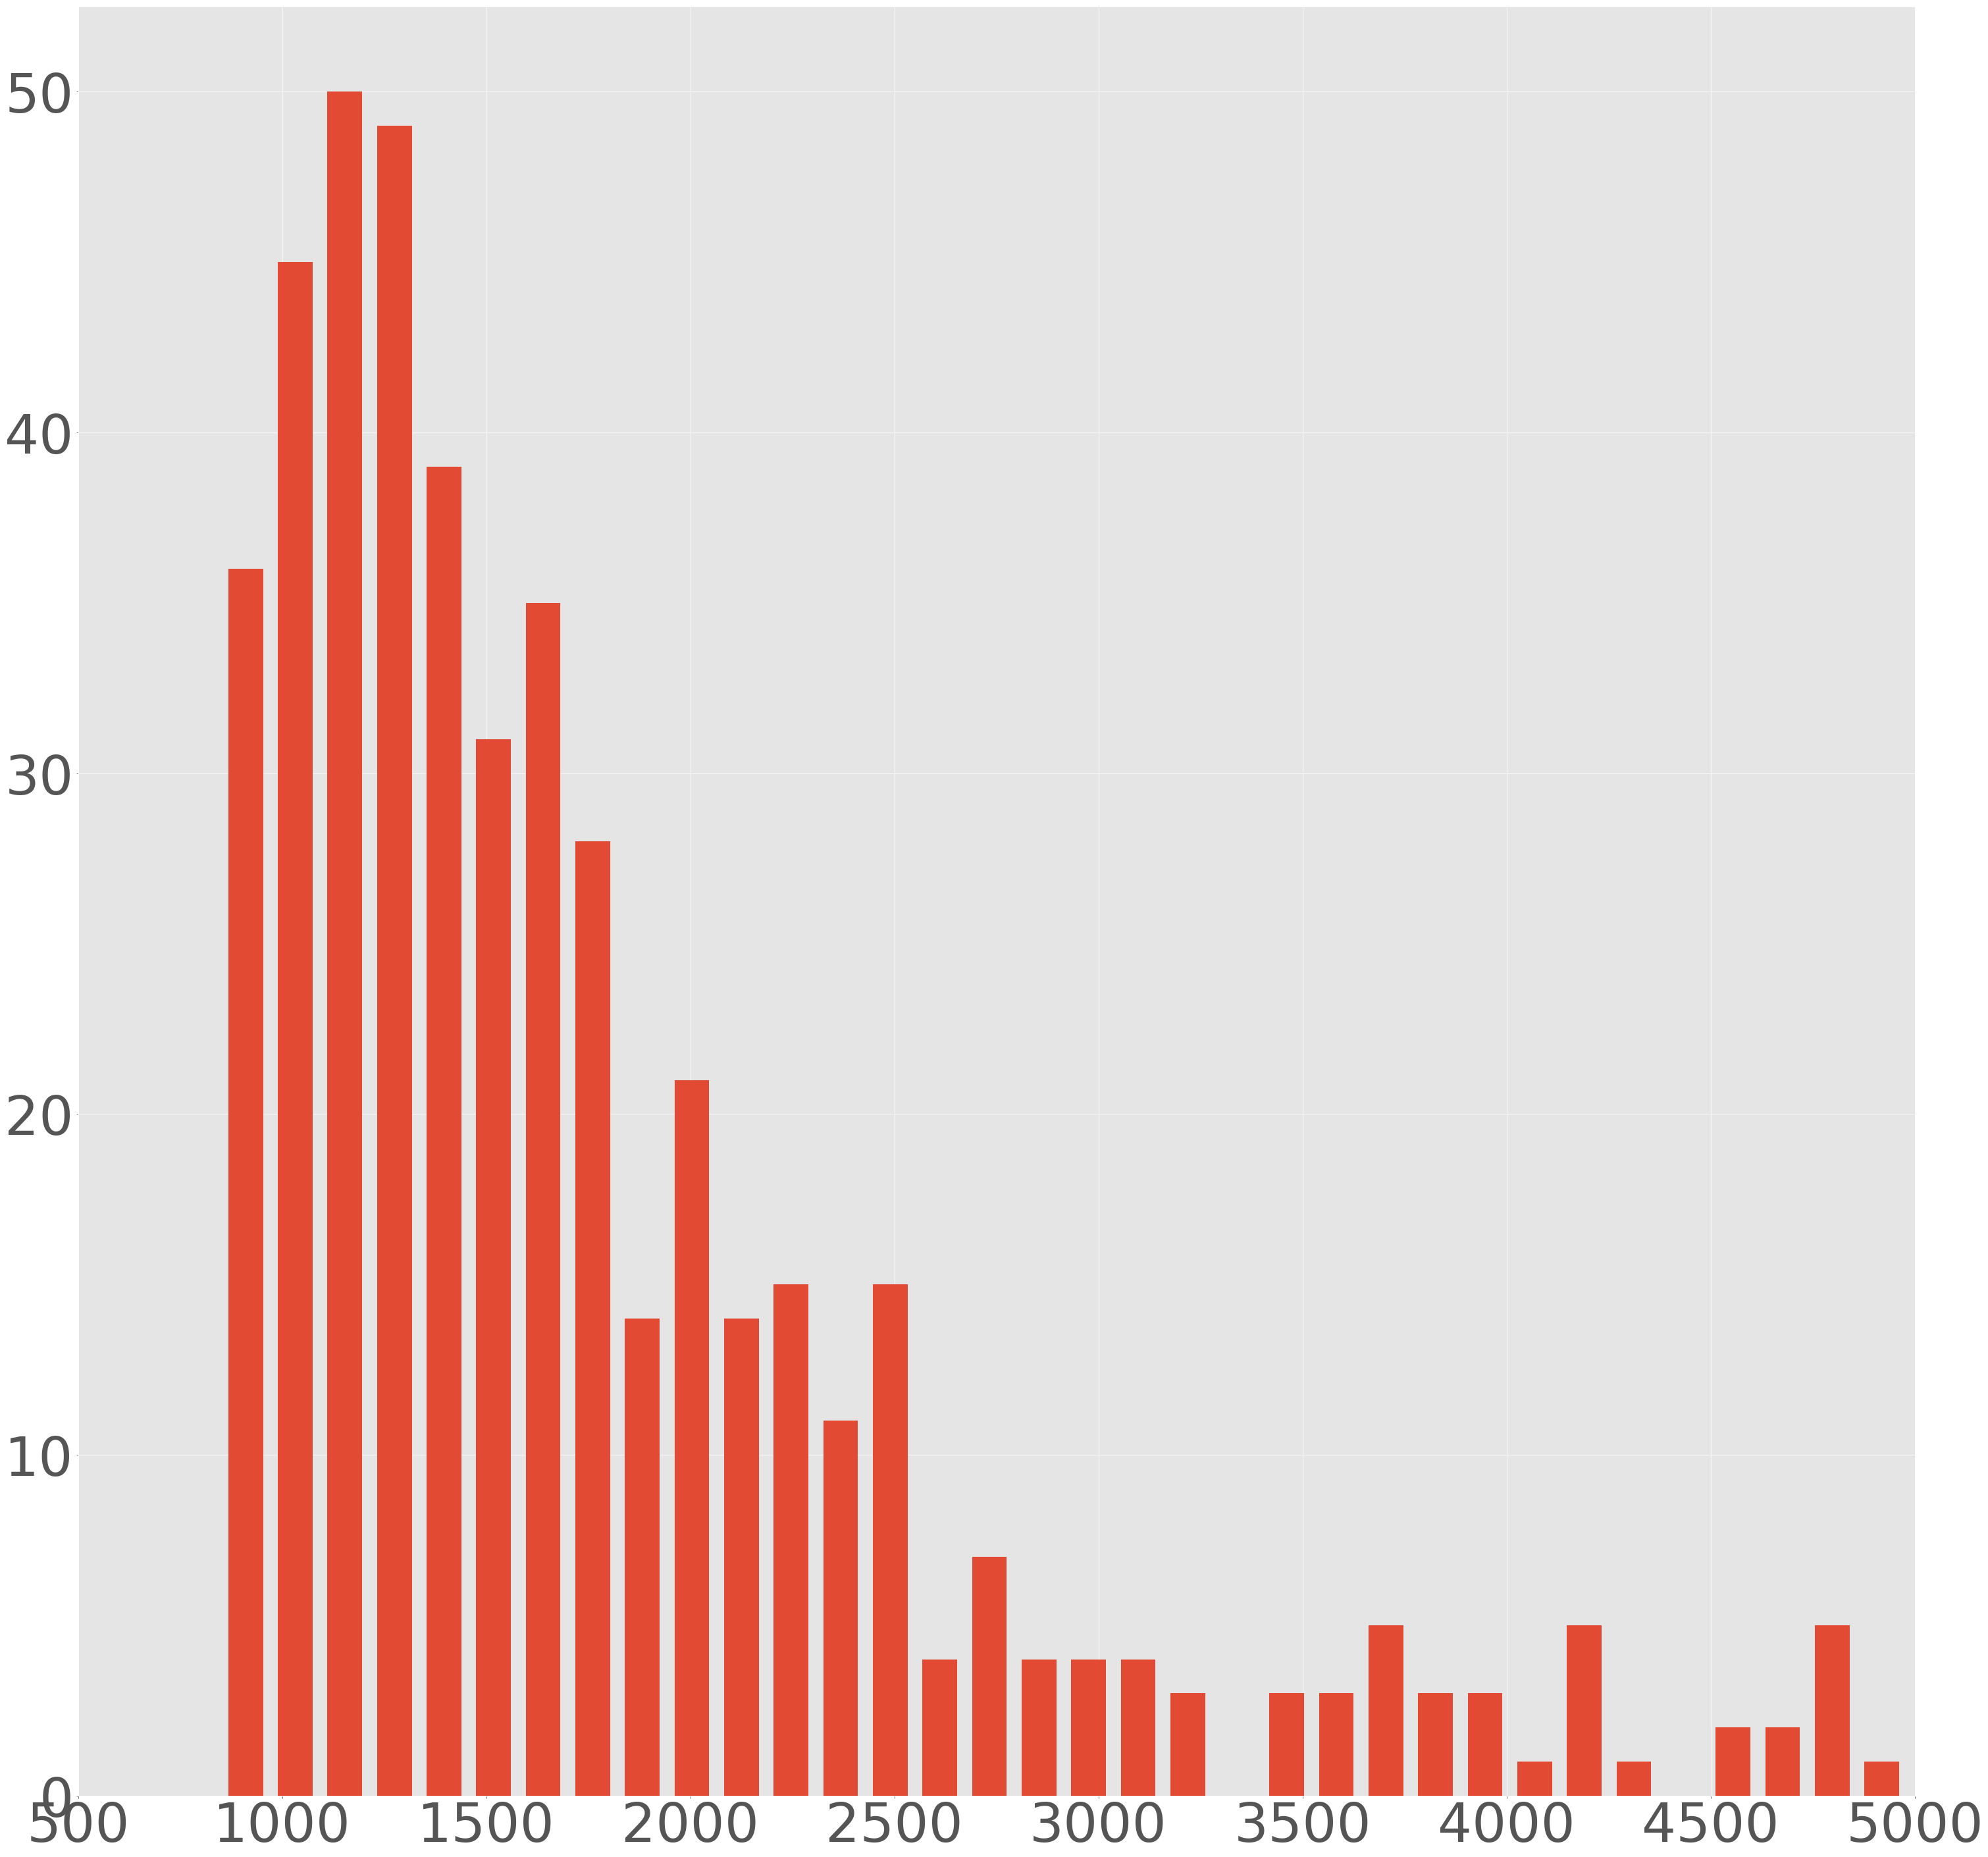

In [73]:
hist, bins = np.histogram(masses, density=False, bins=100)
center = (bins[:-1] + bins[1:]) / 2
width = 0.7 * (bins[1] - bins[0])
plt.bar(center, hist, align='center', width=width)
plt.xlim((500,5000))

AttributeError: 'numpy.ndarray' object has no attribute 'append'

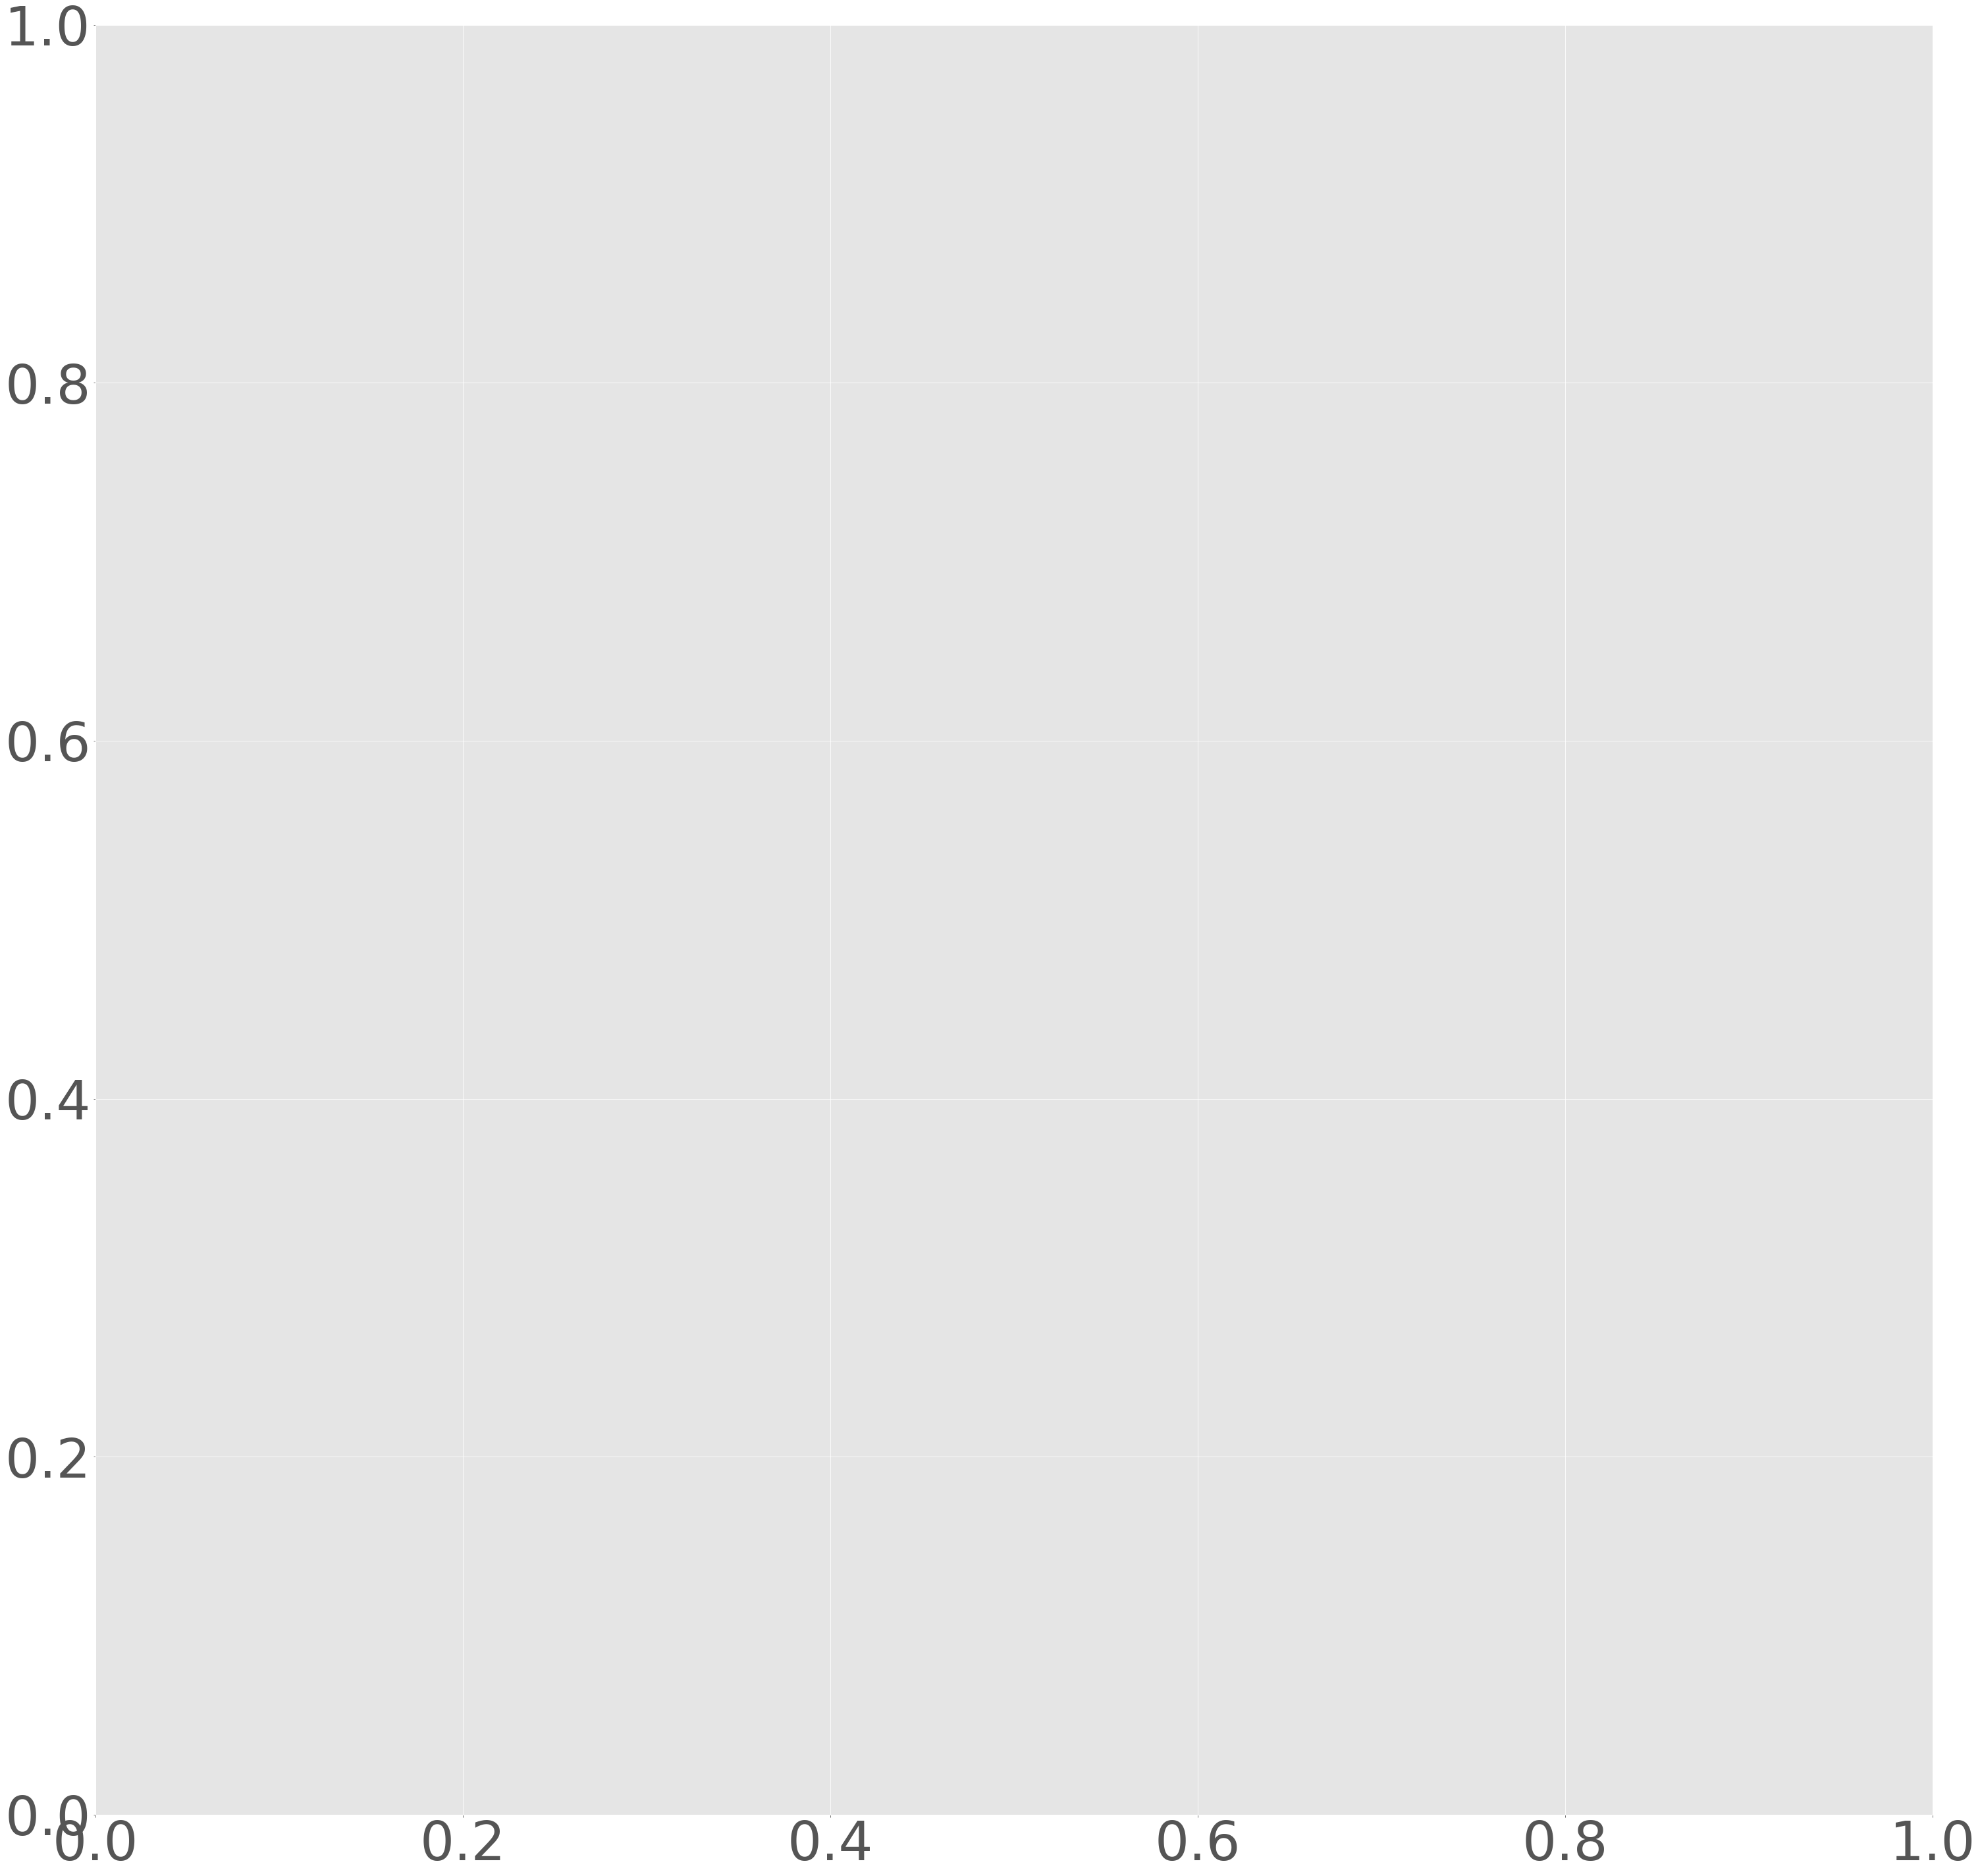

In [122]:
fig, ax = plt.subplots()
D_30_40_sum = D_30.append(D_40)
ax.hist(D_30_40, bins=100, alpha=0.5)
ax.hist(D_30_40_sum, bins=100, alpha=0.5)

ax.set_title('Comparison measurement and sum')
ax.set(xlabel='D (pixels)$^2$/s', ylabel='count')
ax.set_xlim(0,150)
ax.legend(('30nm and 40nm', 'Adding 30 and 40'))